# Оценка риска ДТП  на каршеринге

Для каршеринговой компании требуется создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Подключитесь к базе. Загрузите таблицы sql

**Загружаем необходимые библиотеки и инструменты**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import random

from sqlalchemy import create_engine

#!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
import re

import time
import tqdm

import warnings
warnings.filterwarnings('ignore')

**Напишем вспомогательные фунцкции**

In [2]:
def df_info(df, name):
    
    '''Подробная информация о конкретном DF'''
    
    df.name = name
    
    print(f'Информация о {df.name} (кол-во столбцов {df.shape[1]}, кол-во строк {df.shape[0]})')
    print()
    
    display(df.head(10), df.info(memory_usage = True), df.describe())

def data_spread(df, column_list):
    
    '''Разброс данных. Отображение диаграммы размаха и гистограммы. Входные данные list колонок и df'''
    
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха на столбце {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма на столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()
        print('--------------------------------------------')
        
def uniqueness(df, column_list):
    
    '''Просмотр уникальных значений листа'''
    
    for column in column_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print(df[column].value_counts())
        print('-----------------------------')       
        
def learning_time(model, features_train, target_train):
    '''Считает время обучения модели'''
    start = time.time()
    model.fit(features_train, target_train)
    end = time.time()
    learning_time = end - start
    return model, learning_time

def predict_time(model, features_test):
    '''Считает время предсказания модели'''
    start = time.time()
    predicts = model.predict(features_test)
    end = time.time()
    predict_time = end - start
    return predicts, predict_time

def alter_table(df, model, recall, learning_time, predic_time):
    '''Добавляет в нашу таблицу с анализом моделей данные'''
    
    analytics.loc[model, 'Recall'] = recall
    analytics.loc[model, 'LearningTime'] = learning_time
    analytics.loc[model, 'PredictTime'] = predic_time
    
    return df

**Подключимся к базе данных**

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [5]:
engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

**Исследуем таблицы**

In [6]:
collisions = '''

SELECT *
FROM collisions

'''

parties = '''

SELECT *
FROM parties

'''

vehicles = '''

SELECT *
FROM vehicles

'''

case_ids = '''

SELECT *
FROM case_ids

'''

**Ограничим числа двумя знаками после запятой**

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**Изучим таблицу `collisions`**

In [8]:
collisions = pd.read_sql_query(collisions, con = engine)

In [9]:
df_info(collisions, 'collisions')

Информация о collisions (кол-во столбцов 20, кол-во строк 1400000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       13720

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00,north,0.00,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00,None,1.00,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.00,None,1.00,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.00,south,0.00,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.00,south,0.00,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.00,north,0.00,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.00,None,1.00,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


None

,distance,intersection,party_count
count,1400000.00,1387781.00,1400000.00
mean,660.71,0.22,1.97
std,11785.79,0.42,0.67
min,0.00,0.00,1.00
25%,2.00,0.00,2.00
50%,100.00,0.00,2.00
75%,430.00,0.00,2.00
max,8363520.00,1.00,27.00


**Изучим таблицу `parties`**

In [10]:
parties = pd.read_sql_query(parties, con = engine)

In [11]:
df_info(parties, 'parties')

Информация о parties (кол-во столбцов 9, кол-во строк 2752408)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00,had not been drinking,None,0.00
1,23,3899454,2,road signs,0,7.00,had not been drinking,None,0.00
2,29,3899462,2,car,0,21.00,had not been drinking,None,0.00
3,31,3899465,2,road signs,0,24.00,had not been drinking,None,0.00
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.00
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.00
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.00
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.00
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


None

,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,2752408.00,2752408.00,2752408.00,2347006.00,2240771.00
mean,1376204.50,1.60,0.47,38.75,0.02
std,794551.89,0.72,0.50,16.38,0.14
min,1.00,1.00,0.00,0.00,0.00
25%,688102.75,1.00,0.00,25.00,0.00
50%,1376204.50,1.00,0.00,36.00,0.00
75%,2064306.25,2.00,1.00,50.00,0.00
max,2752408.00,27.00,1.00,105.00,1.00


**Изучим таблицу `vehicles`**

In [12]:
vehicles = pd.read_sql_query(vehicles, con = engine)

In [13]:
df_info(vehicles, 'vehicles')

Информация о vehicles (кол-во столбцов 6, кол-во строк 1021234)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.00
1,1,3858022,1,sedan,auto,3.00
2,1175712,5305030,1,sedan,auto,3.00
3,1175717,5305033,3,sedan,auto,5.00
4,1175722,5305034,2,sedan,auto,5.00
5,1175737,5305046,2,sedan,auto,5.00
6,1175750,5305053,3,sedan,auto,9.00
7,1175715,5305033,1,sedan,manual,10.00
8,1175716,5305033,2,sedan,manual,4.00
9,1175758,5305060,2,sedan,auto,11.00


None

,id,party_number,vehicle_age
count,1021234.00,1021234.00,996652.00
mean,760162.80,1.61,5.14
std,438619.36,0.68,3.11
min,1.00,1.00,0.00
25%,380694.25,1.00,3.00
50%,761762.50,2.00,5.00
75%,1141347.75,2.00,7.00
max,1517654.00,27.00,161.00


**Изучим таблицу `case_ids`**

In [14]:
case_ids = pd.read_sql_query(case_ids, con = engine)
df_info(case_ids, 'case_ids')

Информация о case_ids (кол-во столбцов 2, кол-во строк 1400000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


None

,case_id,db_year
count,1400000,1400000
unique,1400000,1
top,0081715,2021
freq,1,1400000


**Посмотрим наличие уникальных case_id из `case_ids` в каждой таблице**

In [15]:
print('Разность case_ids и collisions =', len(case_ids['case_id']) - len(list(set(case_ids['case_id']) & set(collisions['case_id'].unique()))))
print('Разность case_ids и parties =', len(case_ids['case_id']) - len(list(set(case_ids['case_id']) & set(parties['case_id'].unique()))))
print('Разность case_ids и vehicles =', len(case_ids['case_id']) - len(list(set(case_ids['case_id']) & set(vehicles['case_id'].unique()))))

Разность case_ids и collisions = 0
Разность case_ids и parties = 0
Разность case_ids и vehicles = 607358


По первичному анализу видно, что в таблицах в некоторых столбцах есть пропуски. Таблица `vehicles` содержит менее половины уникальных case_id, это можно объяснить тем, что в аварии участвует как правило два и более автомобилей, соответственно каждый case_id в этой таблице встречается два и более раз.

##  Проведите статистический анализ факторов ДТП

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Сгруппируем данные по месяцам, чтобы посмотреть их распределение**

In [17]:
time_series = """

SELECT DATE_TRUNC('MONTH', COLLISION_DATE) AS date_trunc,
       COUNT(CASE_ID)
FROM collisions
GROUP BY DATE_TRUNC('MONTH', COLLISION_DATE);

"""

time_series = pd.read_sql_query(time_series, con = engine)
time_series.sort_values(by = 'date_trunc')

,date_trunc,count
0,2009-01-01 00:00:00+03:00,35062
1,2009-02-01 00:00:00+03:00,34480
2,2009-03-01 00:00:00+03:00,36648
3,2009-04-01 00:00:00+04:00,35239
4,2009-05-01 00:00:00+04:00,36916
5,2009-06-01 00:00:00+04:00,34202
6,2009-07-01 00:00:00+04:00,35161
7,2009-08-01 00:00:00+04:00,34508
8,2009-09-01 00:00:00+04:00,35555
9,2009-10-01 00:00:00+04:00,37835


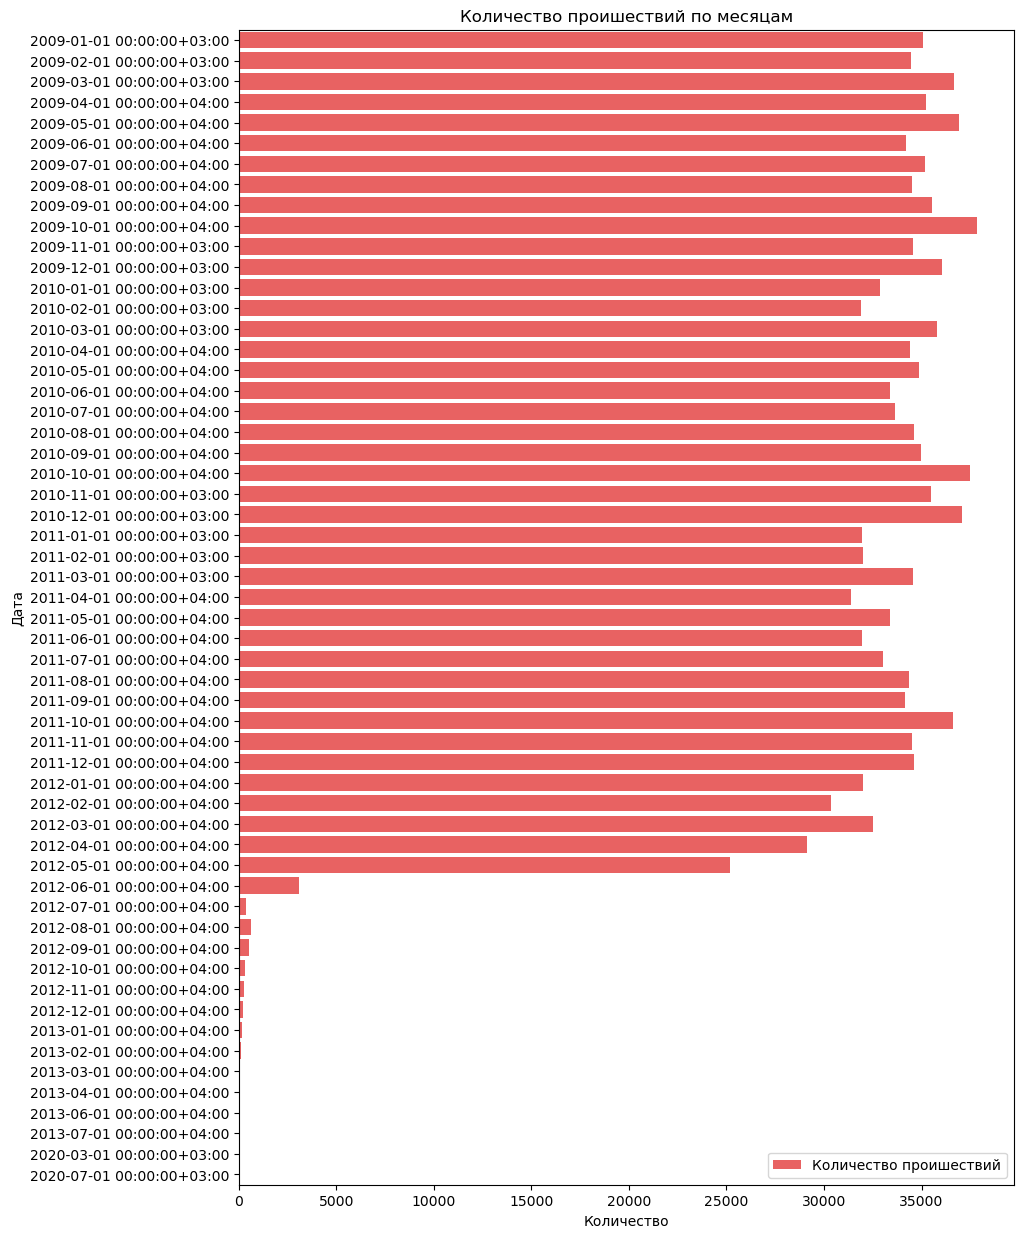

In [18]:
f, ax = plt.subplots(figsize=(10, 15))
sns.barplot(data=time_series, 
            x='count',
            y = 'date_trunc',
            palette = ['r'],
            alpha=0.7, label = 'Количество проишествий', ax=ax)
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")
#plt.xticks(rotation=90)
plt.title("Количество проишествий по месяцам")
plt.show()

По месяцам количество происшествий не сильно отличается, только с середины 2012 года их количество заметно упало. Это вряд ли можно объяснить тем, что происшествий стало сильно меньше, скорее всего таблица по каким-то причинам содержит неполные данные.

**Посмотрим на зависимость покрытия дороги от месяца**

In [19]:
month_road_surface = '''

SELECT EXTRACT(MONTH FROM COLLISION_DATE) AS accidents_date,
       ROAD_SURFACE,
       COUNT(CASE_ID) AS accidents_mean
FROM collisions
GROUP BY EXTRACT(MONTH FROM COLLISION_DATE), ROAD_SURFACE
ORDER BY accidents_date, accidents_mean DESC;

'''
month_list = {1 : 'Январь',
              2 : 'Февраль',
              3 : 'Март',
              4 : 'Апрель',
              5 : 'Май',
              6 : 'Июнь',
              7 : 'Июль',
              8 : 'Август',
              9 : 'Сентябрь',
              10 : 'Октябрь',
              11 : 'Ноябрь',
              12 : 'Декабрь'} 

month_road_surface = pd.read_sql_query(month_road_surface, con = engine)

month_road_surface['accidents_date'] = month_road_surface['accidents_date'].replace(month_list)

month_road_surface

,accidents_date,road_surface,accidents_mean
0,Январь,dry,108355
1,Январь,wet,20974
2,Январь,snowy,1424
3,Январь,None,1135
4,Январь,slippery,156
5,Февраль,dry,99483
6,Февраль,wet,26404
7,Февраль,snowy,1673
8,Февраль,None,1160
9,Февраль,slippery,138


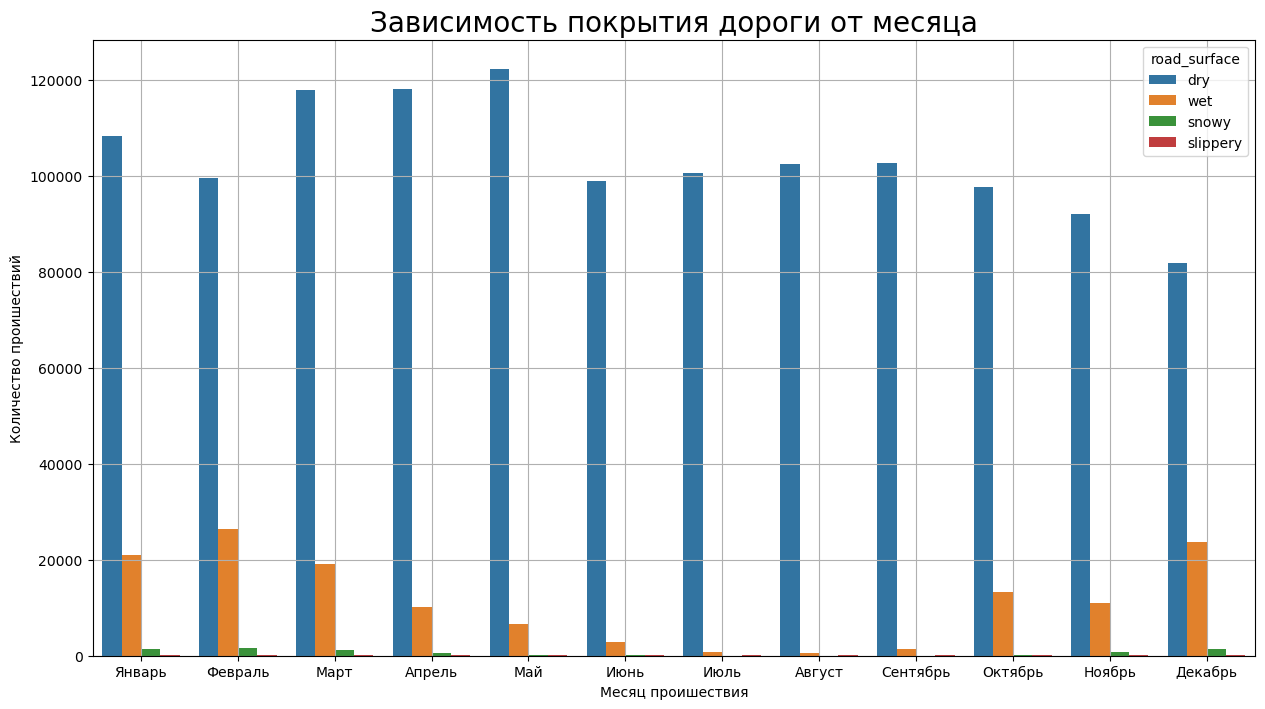

In [20]:
plt.figure(figsize=(15, 8))
sns.barplot(data=month_road_surface, x="accidents_date", y="accidents_mean", hue="road_surface")
plt.title('Зависимость покрытия дороги от месяца', fontsize=20)
plt.xlabel('Месяц проишествия')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

В основном дорога во время происшествий сухая, в тёплое время года дорога практически всегда сухая, зимой в четверти случаев мокрая, а снежная совсем редко.

In [21]:
month_weather = '''

SELECT EXTRACT(MONTH FROM COLLISION_DATE) AS accidents_date,
       WEATHER_1,
       COUNT(CASE_ID) AS accidents_mean
FROM collisions
GROUP BY EXTRACT(MONTH FROM COLLISION_DATE), WEATHER_1
ORDER BY accidents_date, accidents_mean DESC;

'''

month_weather = pd.read_sql_query(month_weather, con = engine)

month_weather['accidents_date'] = month_weather['accidents_date'].replace(month_list)

month_weather

,accidents_date,weather_1,accidents_mean
0,Январь,clear,97133
1,Январь,cloudy,23252
2,Январь,raining,8108
3,Январь,fog,2231
4,Январь,None,700
5,Январь,snowing,407
6,Январь,other,162
7,Январь,wind,51
8,Февраль,clear,85363
9,Февраль,cloudy,29700


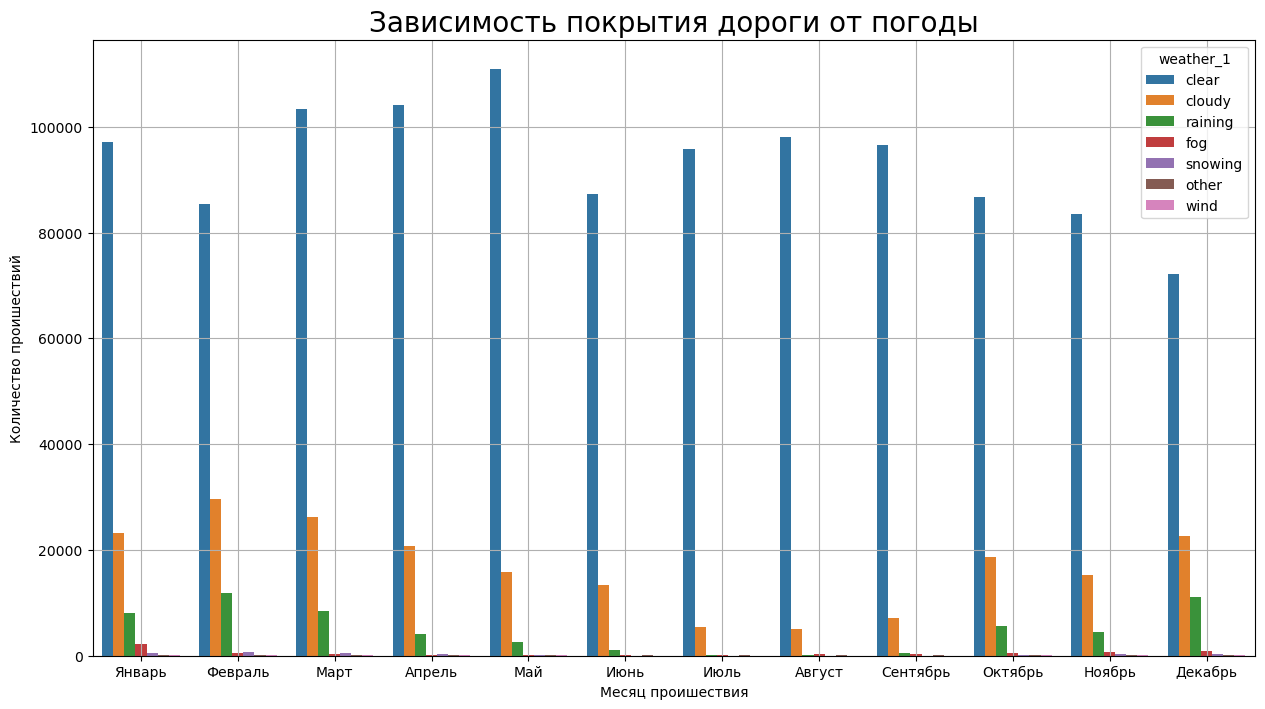

In [22]:
plt.figure(figsize=(15, 8))
sns.barplot(data=month_weather, x="accidents_date", y="accidents_mean", hue="weather_1")
plt.title('Зависимость покрытия дороги от погоды', fontsize=20)
plt.xlabel('Месяц проишествия')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

Погодные условия тоже зависят от времени года, летом абсолютное большинство происшествий происходит при ясной погоде, зимой до трети происшествий происходит в облачную погоду.

In [23]:
month_light = '''

SELECT EXTRACT(MONTH FROM COLLISION_DATE) AS accidents_date,
       LIGHTING,
       COUNT(CASE_ID) AS accidents_mean
FROM collisions
GROUP BY EXTRACT(MONTH FROM COLLISION_DATE), LIGHTING
ORDER BY accidents_date, accidents_mean DESC;

'''

month_light = pd.read_sql_query(month_light, con = engine)

month_light['accidents_date'] = month_light['accidents_date'].replace(month_list)

month_light

,accidents_date,lighting,accidents_mean
0,Январь,daylight,75823
1,Январь,dark with street lights,36271
2,Январь,dark with no street lights,13199
3,Январь,dusk or dawn,5395
4,Январь,None,807
5,Январь,dark with street lights not functioning,549
6,Февраль,daylight,79038
7,Февраль,dark with street lights,32477
8,Февраль,dark with no street lights,11280
9,Февраль,dusk or dawn,4867


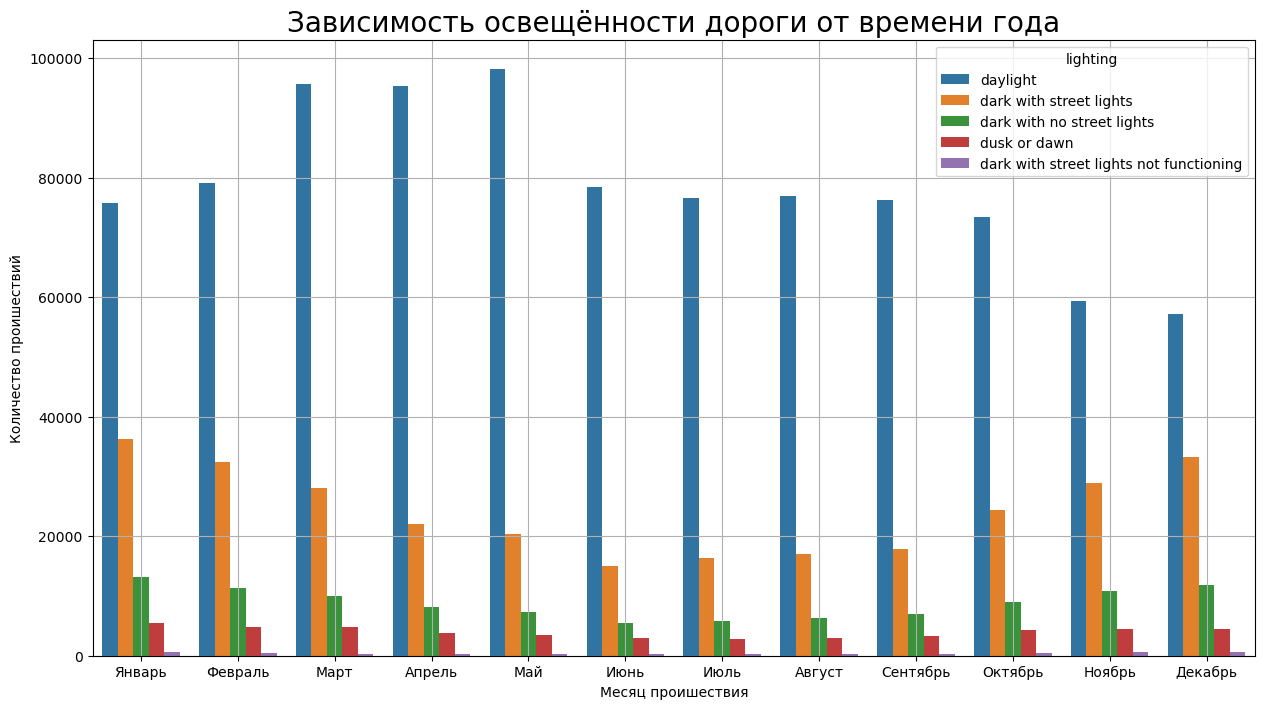

In [24]:
plt.figure(figsize=(15, 8))
sns.barplot(data=month_light, x="accidents_date", y="accidents_mean", hue="lighting")
plt.title('Зависимость освещённости дороги от времени года', fontsize=20)
plt.xlabel('Месяц проишествия')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

Абсолютное большинство происшествий происходит в дневное время, зимой около трети происшествий происходит в тёмное время суток при уличном освещеении.

In [25]:
bad_areas = '''

SELECT COUNTY_LOCATION,
       COUNT(CASE_ID)
FROM collisions
GROUP BY COUNTY_LOCATION
ORDER BY COUNT(CASE_ID) DESC;

'''

bad_areas = pd.read_sql_query(bad_areas, con = engine)
bad_areas

,county_location,count
0,los angeles,433809
1,orange,118276
2,san bernardino,79382
3,san diego,78391
4,riverside,69328
5,alameda,64553
6,sacramento,56988
7,santa clara,50786
8,ventura,32335
9,contra costa,31492


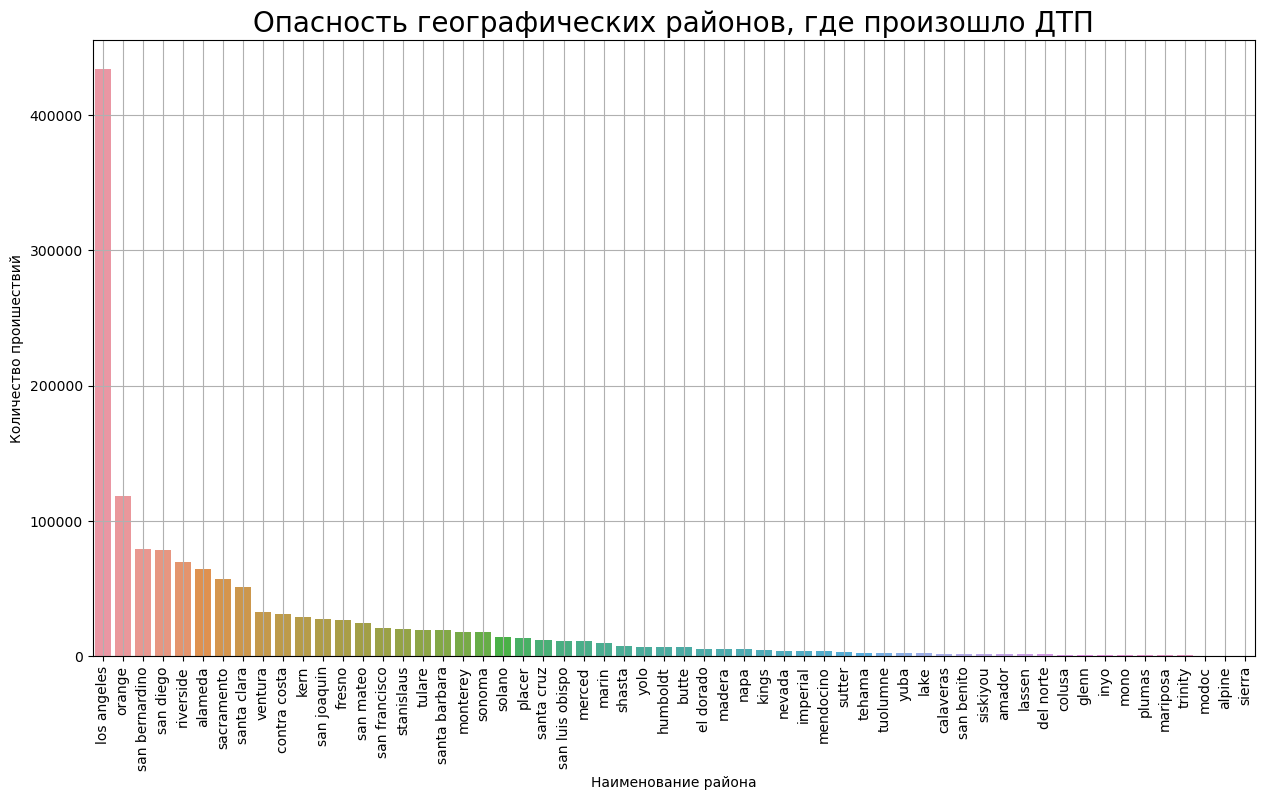

In [26]:
plt.figure(figsize=(15, 8))
sns.barplot(data=bad_areas, x="county_location", y="count")
plt.title('Опасность географических районов, где произошло ДТП', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Наименование района')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

Самое значителное количество ДТП происходит в Лос-Анджелесе, это можно объяснить большой густонаселённостью этого района.

In [27]:
region_road_condition = '''

WITH a AS 
(SELECT COUNTY_LOCATION,
       COUNT(CASE_ID)
FROM collisions
GROUP BY COUNTY_LOCATION
ORDER BY COUNT(CASE_ID) DESC),

f AS

(SELECT ROW_NUMBER() OVER (PARTITION BY COUNTY_LOCATION ORDER BY COUNT(CASE_ID) DESC),
        COUNTY_LOCATION,
        ROAD_CONDITION_1,
        COUNT(CASE_ID)
FROM collisions
GROUP BY COUNTY_LOCATION, ROAD_CONDITION_1
ORDER BY COUNTY_LOCATION)

SELECT county_location,
       road_condition_1,
       count
FROM f
WHERE row_number < 4 AND county_location IN (SELECT COUNTY_LOCATION
                                          FROM a
                                          LIMIT 10);


'''

region_road_condition = pd.read_sql_query(region_road_condition, con = engine)
region_road_condition

,county_location,road_condition_1,count
0,alameda,normal,62043
1,alameda,construction,1058
2,alameda,None,483
3,contra costa,normal,30386
4,contra costa,construction,354
5,contra costa,None,226
6,los angeles,normal,421004
7,los angeles,construction,3871
8,los angeles,None,3651
9,orange,normal,114031


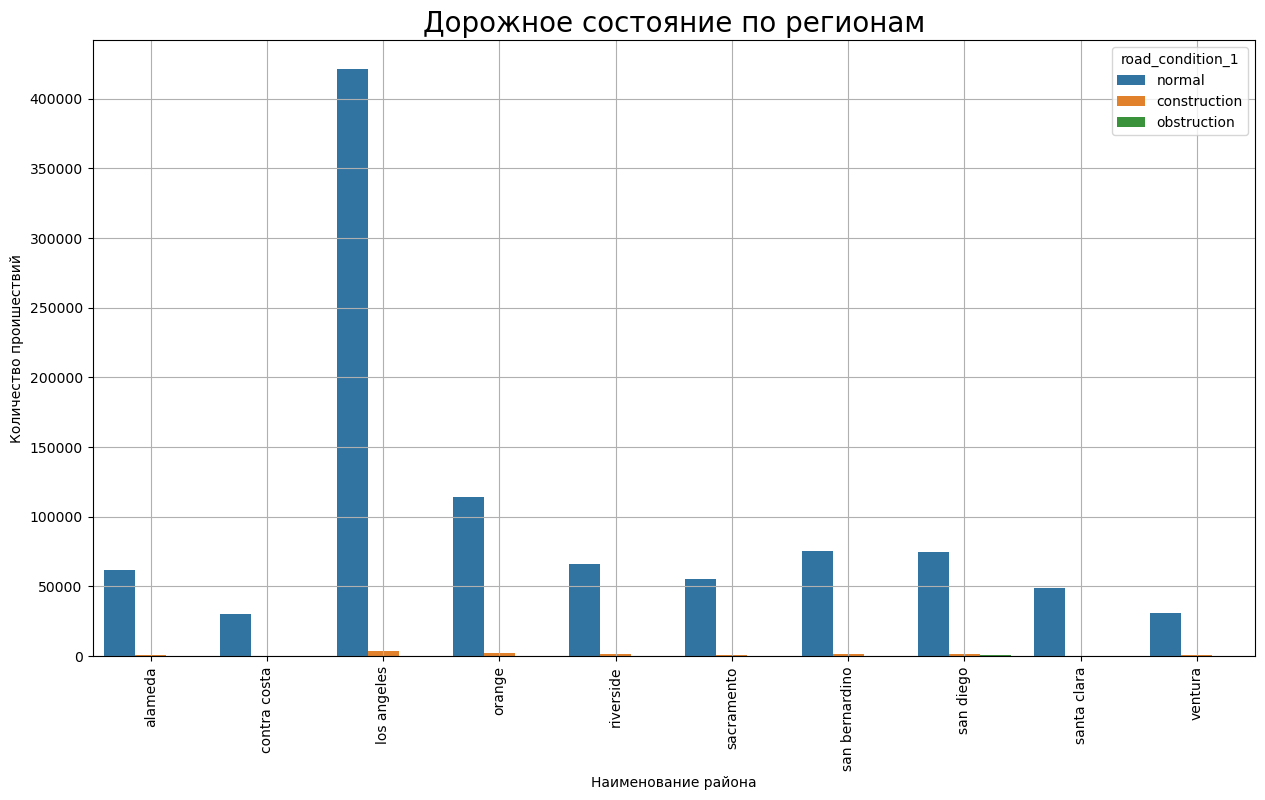

In [28]:
plt.figure(figsize=(15, 8))
sns.barplot(data=region_road_condition, x="county_location", y="count", hue = 'road_condition_1')
plt.title('Дорожное состояние по регионам', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Наименование района')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

Практически все происшествия случились на хорошей дороге не зависимо от района.

In [29]:
violations_category = '''

WITH a AS 
(SELECT COUNTY_LOCATION,
       COUNT(CASE_ID)
FROM collisions
GROUP BY COUNTY_LOCATION
ORDER BY COUNT(CASE_ID) DESC),

f AS

(SELECT ROW_NUMBER() OVER (PARTITION BY COUNTY_LOCATION ORDER BY COUNT(CASE_ID) DESC),
        COUNTY_LOCATION,
        PCF_VIOLATION_CATEGORY,
        COUNT(CASE_ID)
FROM collisions
GROUP BY COUNTY_LOCATION, PCF_VIOLATION_CATEGORY
ORDER BY COUNTY_LOCATION)

SELECT county_location,
       PCF_VIOLATION_CATEGORY,
       count
FROM f
WHERE row_number < 4 AND county_location IN (SELECT COUNTY_LOCATION
                                          FROM a
                                          LIMIT 10);


'''

violations_category = pd.read_sql_query(violations_category, con = engine)
violations_category

,county_location,pcf_violation_category,count
0,alameda,speeding,20721
1,alameda,improper turning,13408
2,alameda,unsafe lane change,5490
3,contra costa,speeding,9797
4,contra costa,improper turning,5343
5,contra costa,automobile right of way,2556
6,los angeles,speeding,135566
7,los angeles,improper turning,58083
8,los angeles,automobile right of way,57609
9,orange,speeding,42328


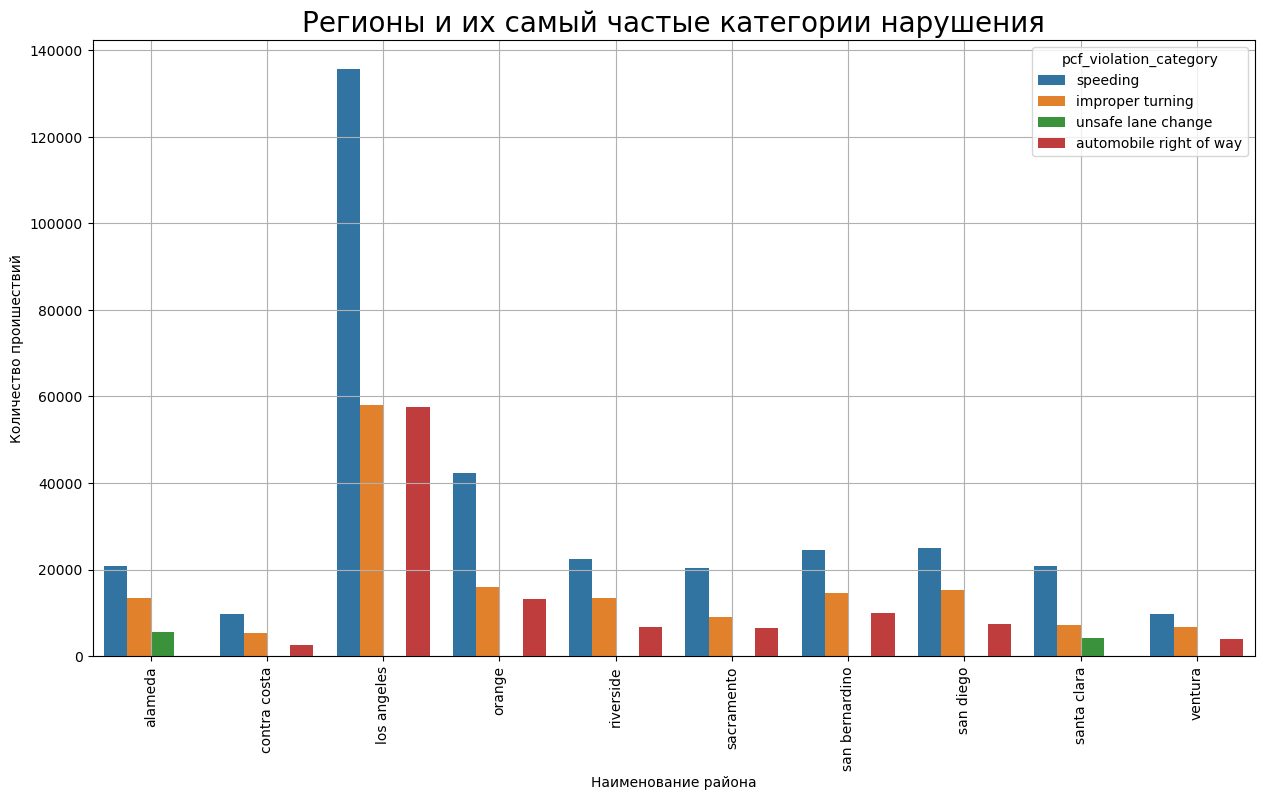

In [30]:
plt.figure(figsize=(15, 8))
sns.barplot(data=violations_category, x="county_location", y="count", hue = 'pcf_violation_category')
plt.title('Регионы и их самый частые категории нарушения', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Наименование района')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

Во всех районах большинство происшествий происходит на скорости, неправильного поворота и несоблюдения правил очередности проезда.

In [31]:
insurance = '''

SELECT AT_FAULT,
       INSURANCE_PREMIUM
FROM parties 

'''

insurance = pd.read_sql_query(insurance, con = engine)

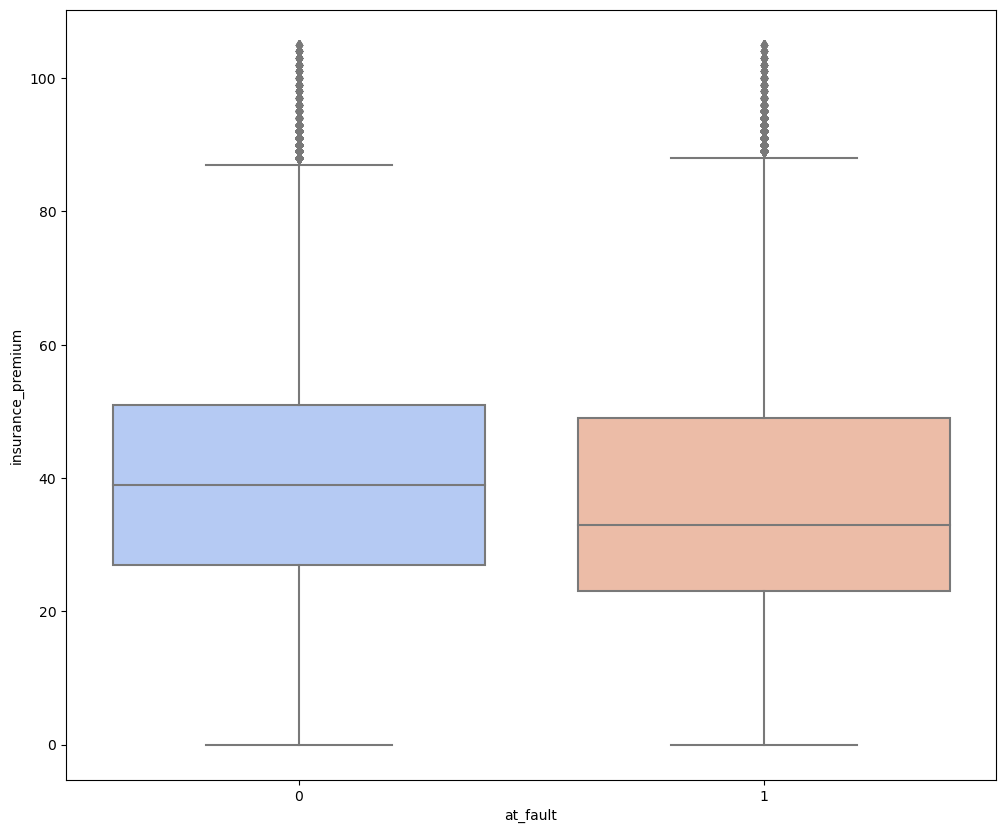

In [32]:
plt.figure(figsize = (12, 10))
sns.boxplot(
    x = insurance.at_fault,
    y = insurance.insurance_premium,
    palette = "coolwarm"
)
plt.show()

Наличие страховки практически не влияет на степень виновности водителя.

In [33]:
vehicle_age = '''

SELECT v.vehicle_age,
       p.at_fault
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id;

'''

vehicle_age = pd.read_sql_query(vehicle_age, con = engine)

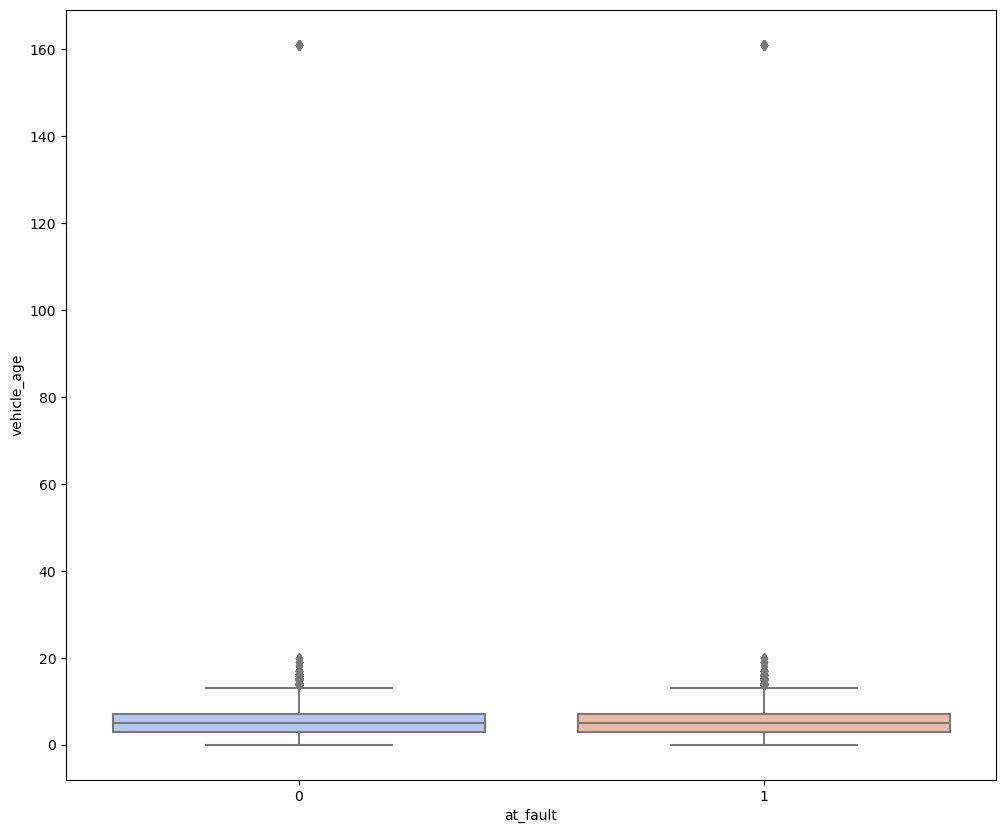

In [34]:
plt.figure(figsize = (12, 10))
sns.boxplot(
    x = vehicle_age.at_fault,
    y = vehicle_age.vehicle_age,
    palette = "coolwarm"
)
plt.show()

Возраст автомобиля тоже не влияет на степень вины водителя. Видны единичные выбросы, исправим это позднее.

**Вывод**

Исходя из временного ряда, можно с уверенностью сказать, что минимальное количество проишествий наблюдается в июле, а самый опасный месяц - октябрь. От части всему виной появление опасных условий, о чём свидетельсвуют графики ДТП относительно времени года и освещения улицы, а также графики ДТП относительно времени года и состояния дороги - мы можем увидеть, что по сравнению с летом, с наступлением осени и до конца марта появляется сырость на дороге, что может способствовать и плохой видимости, ввиду ухудшения погоды, и уменьшению сцепления, если к этому всему прибавить освещённость улиц, которая также возрастает к осени, то в целом данный график можно считать правдивым. 

Скоро состоится первое совещание нашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого ставлю аналитические задачи и поручаю их решение коллегам:

- Влияние типа местности на тип аварии
- Влияние дорожного состояния на категорию повреждения машины
- Зависимость возраста машины от тяжести повреждения
- Необходимость телефона в машине
- Трезвость участника и егосостояние на кол-во аварий
- Зависимость серьёзности повреждений от основного фактора нарушения

**Пример решения задачи**

In [35]:
terrain_accident = '''

WITH f AS
(SELECT ROW_NUMBER() OVER (PARTITION BY LOCATION_TYPE ORDER BY COUNT(CASE_ID) DESC),
       LOCATION_TYPE,
       TYPE_OF_COLLISION,
       COUNT(CASE_ID)
       
FROM collisions
GROUP BY LOCATION_TYPE, TYPE_OF_COLLISION
ORDER BY location_type)

SELECT location_type,
       type_of_collision, 
       count
FROM f
WHERE row_number < 4 AND location_type != 'None';

'''

terrain_accident = pd.read_sql_query(terrain_accident, con = engine)
terrain_accident

,location_type,type_of_collision,count
0,highway,rear end,205121
1,highway,hit object,88451
2,highway,sideswipe,76472
3,intersection,broadside,13247
4,intersection,rear end,4818
5,intersection,sideswipe,3039
6,ramp,rear end,29692
7,ramp,hit object,18708
8,ramp,sideswipe,11047


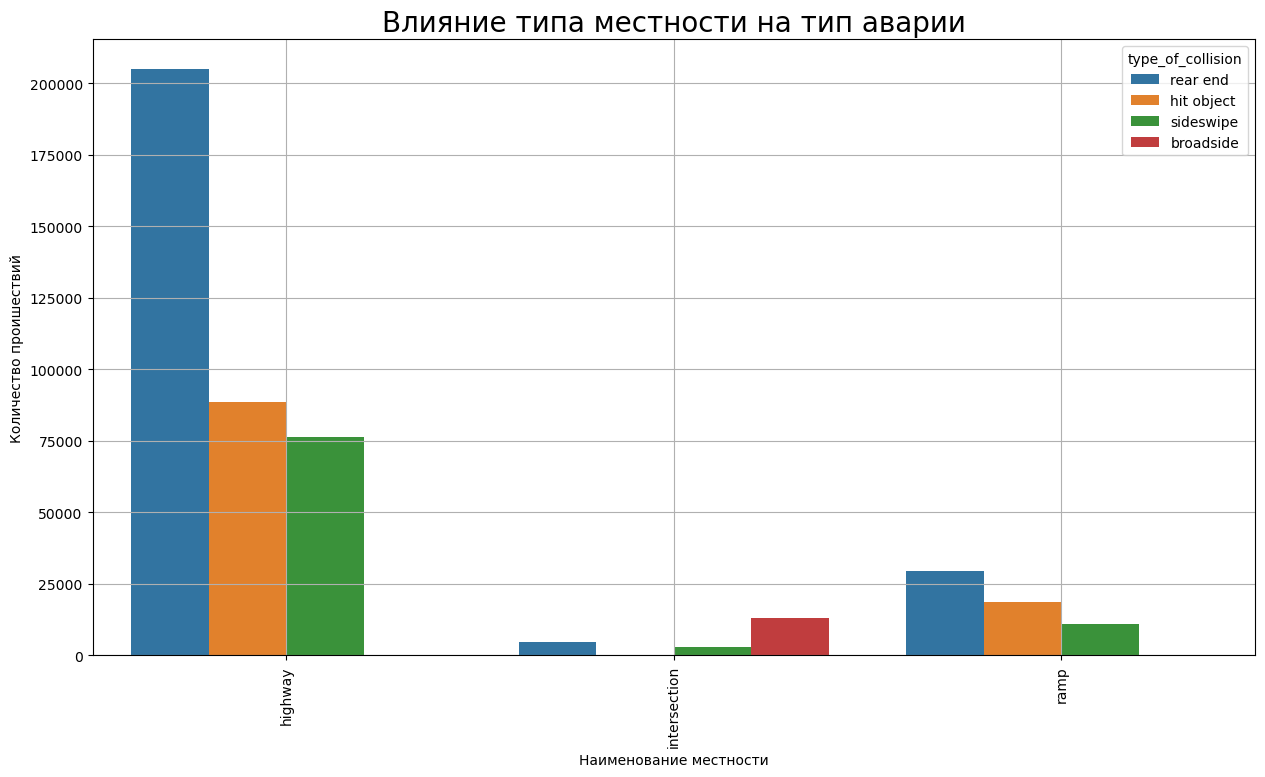

In [36]:
plt.figure(figsize=(15, 8))
sns.barplot(data=terrain_accident, x="location_type", y="count", hue = 'type_of_collision')
plt.title('Влияние типа местности на тип аварии', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Наименование местности')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

На шоссе и рампе лидируют столкновение в заднюю часть автомобиля, затем столкновение с дорожными объектами и боковое столкновение, на перекрёстке лидирует удар в бок автомобиля.

In [37]:
road_condition = '''

WITH f AS
(SELECT ROW_NUMBER() OVER (PARTITION BY ROAD_CONDITION_1 ORDER BY COUNT(CASE_ID) DESC),
       ROAD_CONDITION_1,
       COLLISION_DAMAGE,
       COUNT(CASE_ID)
       
FROM collisions
GROUP BY ROAD_CONDITION_1, COLLISION_DAMAGE
ORDER BY ROAD_CONDITION_1)

SELECT ROAD_CONDITION_1,
       COLLISION_DAMAGE, 
       count
FROM f
WHERE row_number < 4 AND road_condition_1 != 'other' AND road_condition_1 != 'None';

'''

road_condition_2 = '''

WITH f AS
(SELECT ROW_NUMBER() OVER (PARTITION BY ROAD_CONDITION_1 ORDER BY COUNT(CASE_ID) DESC),
       ROAD_CONDITION_1,
       COLLISION_DAMAGE,
       COUNT(CASE_ID)
       
FROM collisions
GROUP BY ROAD_CONDITION_1, COLLISION_DAMAGE
ORDER BY ROAD_CONDITION_1)

SELECT ROAD_CONDITION_1,
       COLLISION_DAMAGE, 
       count
FROM f
WHERE row_number < 4 AND road_condition_1 != 'other' AND road_condition_1 != 'None' AND road_condition_1 != 'normal';

'''

road_condition = pd.read_sql_query(road_condition, con = engine)
road_condition_2 = pd.read_sql_query(road_condition_2, con = engine)
road_condition

,road_condition_1,collision_damage,count
0,construction,small damage,12510
1,construction,scratch,4421
2,construction,middle damage,1858
3,flooded,small damage,682
4,flooded,scratch,272
5,flooded,middle damage,134
6,holes,small damage,3135
7,holes,scratch,1365
8,holes,middle damage,793
9,loose material,small damage,1629


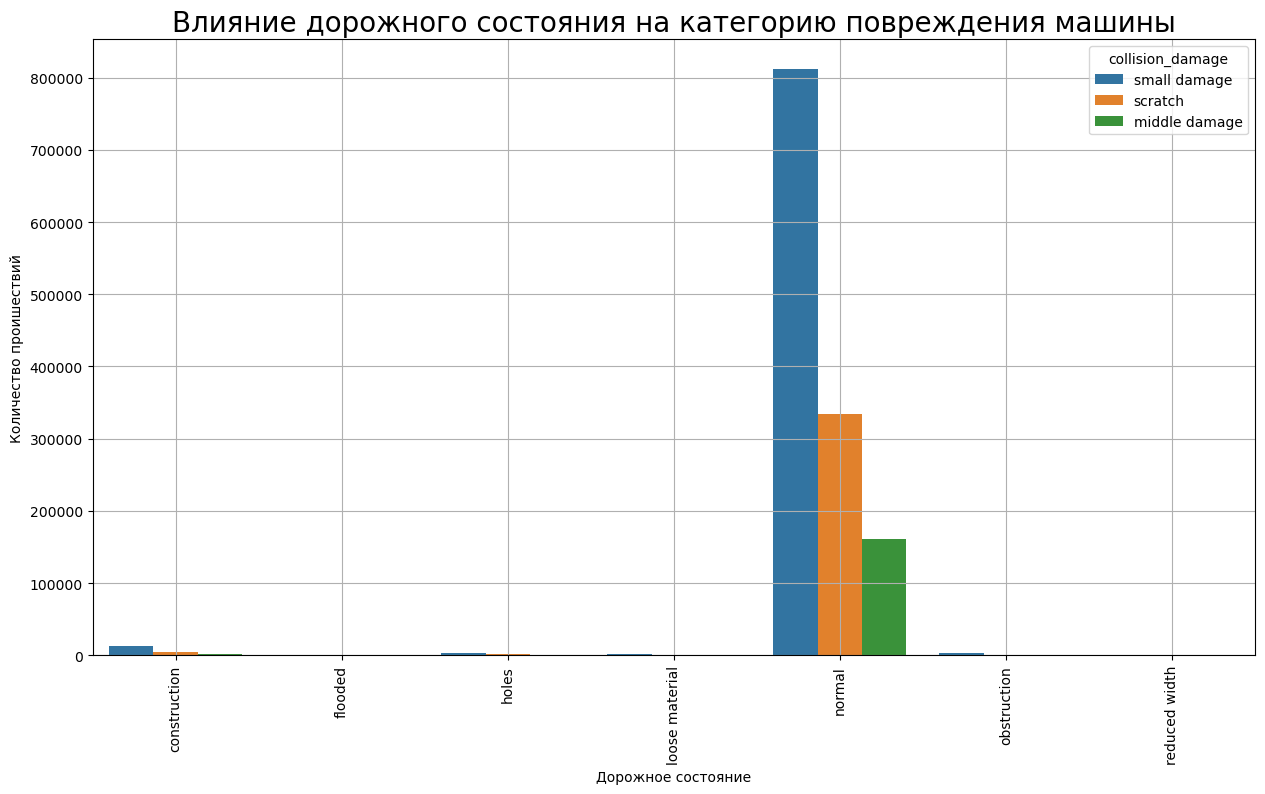

In [38]:
plt.figure(figsize=(15, 8))
sns.barplot(data=road_condition, x="road_condition_1", y="count", hue = 'collision_damage')
plt.title('Влияние дорожного состояния на категорию повреждения машины', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Дорожное состояние')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

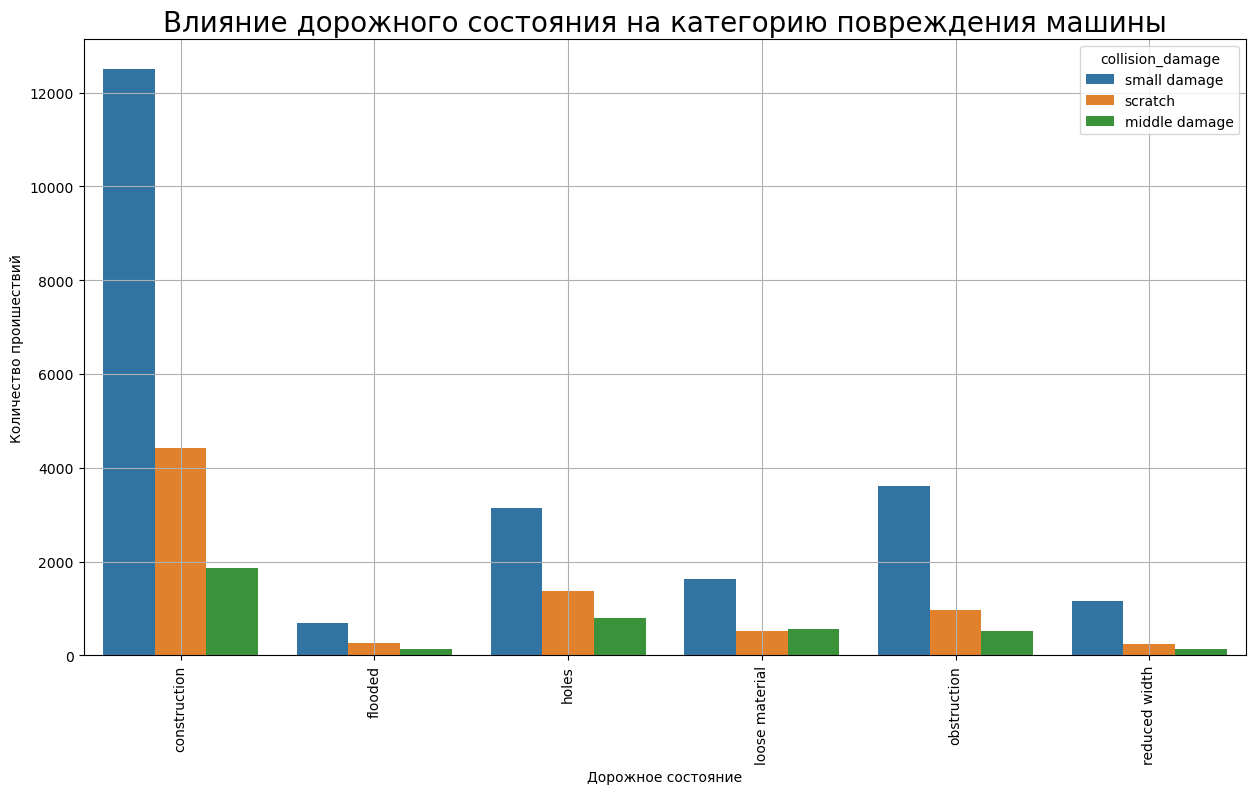

In [39]:
plt.figure(figsize=(15, 8))
sns.barplot(data=road_condition_2, x="road_condition_1", y="count", hue = 'collision_damage')
plt.title('Влияние дорожного состояния на категорию повреждения машины', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Дорожное состояние')
plt.ylabel('Количество проишествий')
plt.grid(True)
plt.show()

В основном при столкновении повреждаются отдельные элементы кузова, на втором месте незначительные повреждения - царапины, на третьем - более серьёзные повреждения, но автомобиль может самостоятельно передвигаться.

In [40]:
phone_car = '''

SELECT v.vehicle_age,
       p.cellphone_in_use
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id;

'''

phone_car = pd.read_sql_query(phone_car, con = engine)
display(phone_car.head(100).style.hide_index())
display(phone_car.tail().style.hide_index())

vehicle_age,cellphone_in_use
3.000000,nan
3.000000,nan
10.000000,nan
9.000000,0.000000
1.000000,0.000000
4.000000,nan
4.000000,0.000000
3.000000,nan
1.000000,0.000000
7.000000,0.000000


vehicle_age,cellphone_in_use
11.000000,0.000000
10.000000,0.000000
11.000000,0.000000
10.000000,0.000000
6.000000,0.000000


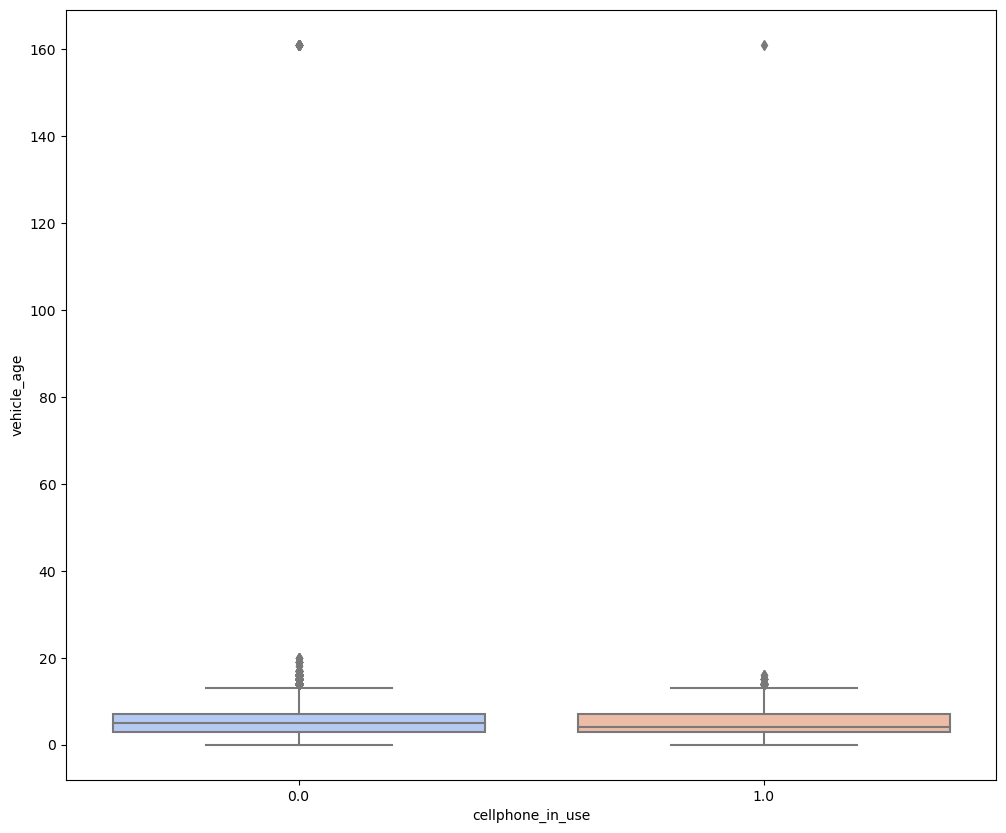

In [41]:
plt.figure(figsize=(12, 10))
sns.boxplot(
x=phone_car.cellphone_in_use,
y=phone_car.vehicle_age,
palette="coolwarm"
)
plt.show()

Наличие систем громкой связи не сильно влияет на виновность водителя.

In [42]:
insurance_age = '''

SELECT v.VEHICLE_AGE,
       AVG(p.INSURANCE_PREMIUM)
FROM vehicles AS v
INNER JOIN parties AS p ON v.CASE_ID = p.CASE_ID
WHERE v.VEHICLE_AGE < 100
GROUP BY v.VEHICLE_AGE;

'''

insurance_age = pd.read_sql_query(insurance_age, con = engine)
insurance_age.drop_duplicates(inplace=True)

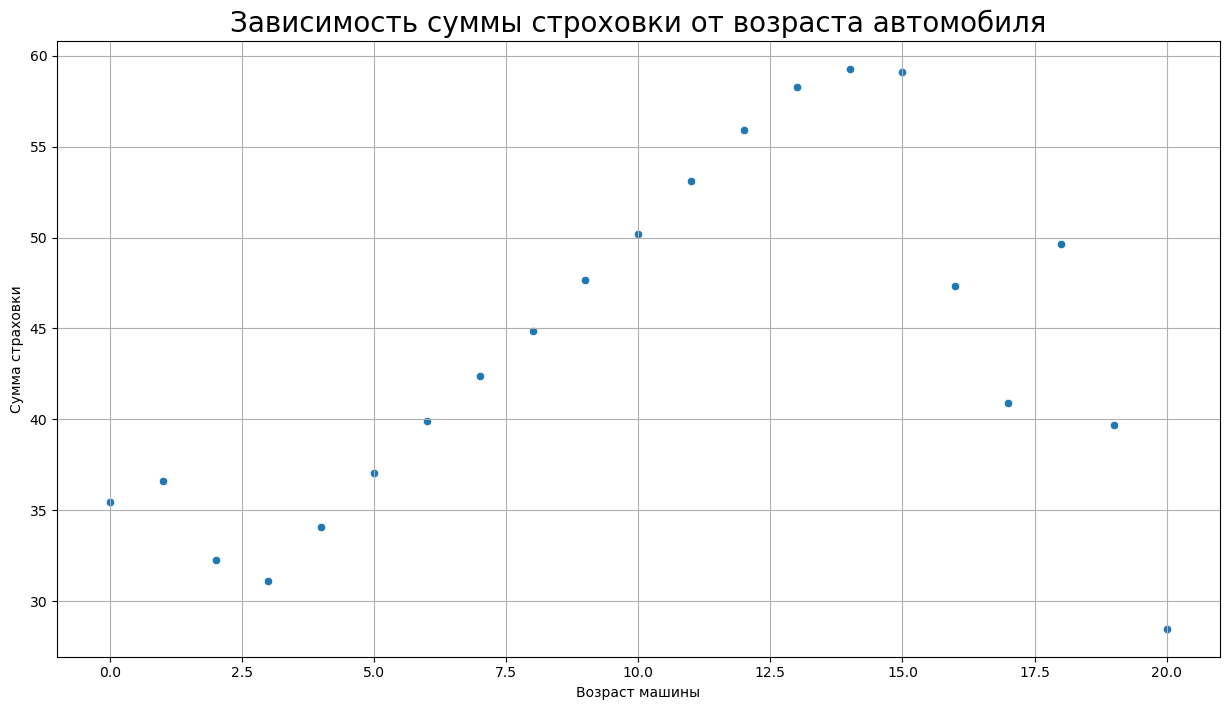


             vehicle_age  avg
vehicle_age         1.00 0.43
avg                 0.43 1.00


In [43]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=insurance_age, x="vehicle_age", y="avg")
plt.title('Зависимость суммы строховки от возраста автомобиля', fontsize=20)
plt.xlabel('Возраст машины')
plt.ylabel('Сумма страховки')
plt.grid(True)
plt.show()

print()

print(insurance_age.corr())

Сумма страховки авто до трёх лет невелика, затем плавно растет для авто до 15-летнего возраста, затем заметно падает.

**Вывод**

Наблюдается определённая зависимость между возрастом автомобиля и его страховкой - для возрастных машин сумма намного больше, чем для новых, однако после 15 лет страховка начинает резко уменьшаться.

Наличие громкой связи в автомобиле не сильно влияет на вознткновение ДТП.

В основном при ДТП повреждаются отдельные элементы кузова.

Основным видом столкновений является удар в заднюю часть автомобиля.

## Создайте модель для оценки водительского риска

**Содадим общий датафрейм, в котором объединим три таблицы по case_id. Дальше будем работать в pandas.**

In [44]:
data = '''

SELECT p.party_number,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age,
       c.county_city_location,
       c.county_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.collision_damage,
       c.party_count,
       c.primary_collision_factor,
       c.pcf_violation_category,
       c.type_of_collision,
       c.motor_vehicle_involved_with,
       c.road_surface,
       c.road_condition_1,
       c.lighting,
       c.control_device,
       c.collision_date,
       c.collision_time,
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use,
       p.at_fault
FROM case_ids AS ci
INNER JOIN vehicles AS v ON ci.CASE_ID = v.CASE_ID
INNER JOIN collisions AS c ON ci.CASE_ID = c.CASE_ID
INNER JOIN parties AS p ON ci.CASE_ID = p.CASE_ID
WHERE p.PARTY_TYPE = 'car' AND c.COLLISION_DAMAGE != 'SCRATCH' AND EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;

'''

In [45]:
data = pd.read_sql_query(data, con = engine)

Изучим полученную таблицу.

In [46]:
df_info(data, 'data')

Информация о data (кол-во столбцов 28, кол-во строк 225778)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225778 entries, 0 to 225777
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   party_number                 225778 non-null  int64  
 1   vehicle_type                 225778 non-null  object 
 2   vehicle_transmission         221360 non-null  object 
 3   vehicle_age                  220220 non-null  float64
 4   county_city_location         225778 non-null  object 
 5   county_location              225778 non-null  object 
 6   distance                     225778 non-null  float64
 7   direction                    164529 non-null  object 
 8   intersection                 225003 non-null  float64
 9   weather_1                    225088 non-null  object 
 10  location_type                95993 non-null   object 
 11  collision_damage             225778 non-null  object 
 1

,party_number,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,at_fault
0,1,sedan,manual,3.00,3500,san benito,0.00,None,1.00,clear,None,fatal,1,vehicle code violation,dui,hit object,fixed object,dry,loose material,dark with street lights,functioning,2012-01-13,02:55:00,19.00,"had been drinking, under influence",under drug influence,0.00,1
1,1,sedan,manual,4.00,0900,el dorado,200.00,north,0.00,clear,None,small damage,2,unknown,unknown,sideswipe,other motor vehicle,dry,normal,daylight,functioning,2012-01-15,16:15:00,25.00,had not been drinking,None,0.00,0
2,1,coupe,manual,2.00,0800,del norte,0.00,None,1.00,clear,ramp,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-01-11,11:10:00,56.00,had not been drinking,None,0.00,0
3,1,coupe,manual,9.00,0800,del norte,0.00,None,1.00,clear,ramp,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-01-11,11:10:00,56.00,had not been drinking,None,0.00,0
4,2,sedan,auto,2.00,3612,san bernardino,300.00,south,0.00,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,motor vehicle on other roadway,dry,normal,daylight,none,2012-01-03,10:25:00,48.00,had not been drinking,None,0.00,0
5,1,coupe,manual,7.00,3001,orange,1000.00,east,0.00,clear,highway,middle damage,4,vehicle code violation,dui,sideswipe,other motor vehicle,dry,construction,dark with street lights,none,2012-01-05,20:28:00,44.00,"had been drinking, under influence",None,0.00,1
6,1,coupe,auto,7.00,3001,orange,1000.00,east,0.00,clear,highway,middle damage,4,vehicle code violation,dui,sideswipe,other motor vehicle,dry,construction,dark with street lights,none,2012-01-05,20:28:00,44.00,"had been drinking, under influence",None,0.00,1
7,2,sedan,manual,NaN,1942,los angeles,0.00,None,1.00,fog,None,small damage,2,vehicle code violation,hazardous parking,rear end,other motor vehicle,wet,normal,dark with street lights,none,2012-01-06,21:40:00,32.00,had not been drinking,None,0.00,0
8,1,sedan,auto,6.00,1952,los angeles,200.00,north,0.00,clear,highway,small damage,3,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-01-04,15:00:00,57.00,had not been drinking,None,0.00,1
9,2,sedan,auto,8.00,3311,riverside,0.00,None,1.00,clear,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2012-01-01,13:32:00,44.00,had not been drinking,None,0.00,0


None

,party_number,vehicle_age,distance,intersection,party_count,insurance_premium,cellphone_in_use,at_fault
count,225778.00,220220.00,225778.00,225003.00,225778.00,216922.00,201001.00,225778.00
mean,1.68,5.26,594.35,0.26,2.42,39.24,0.02,0.45
std,0.83,3.13,5143.29,0.44,0.94,16.27,0.14,0.50
min,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
25%,1.00,3.00,0.00,0.00,2.00,25.00,0.00,0.00
50%,2.00,5.00,100.00,0.00,2.00,37.00,0.00,0.00
75%,2.00,7.00,500.00,1.00,3.00,51.00,0.00,1.00
max,10.00,161.00,1584000.00,1.00,10.00,105.00,1.00,1.00


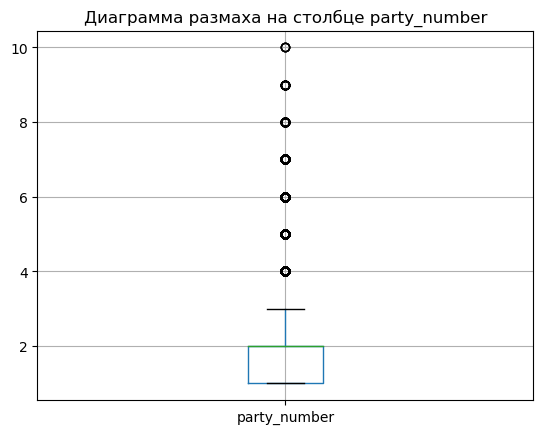

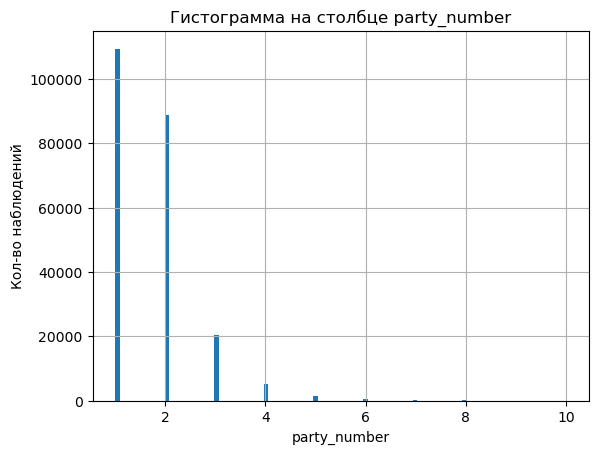

--------------------------------------------


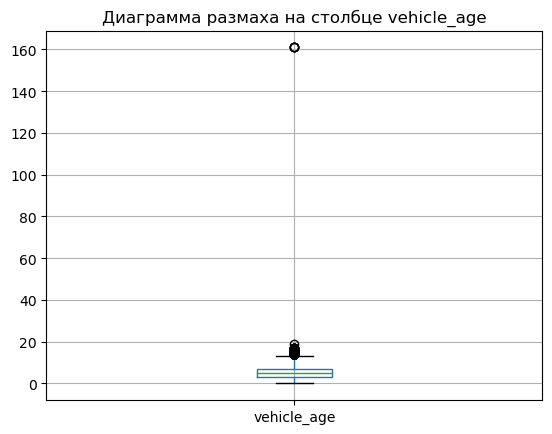

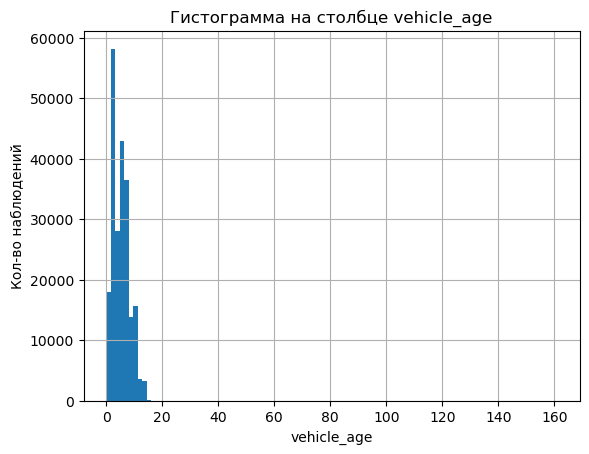

--------------------------------------------


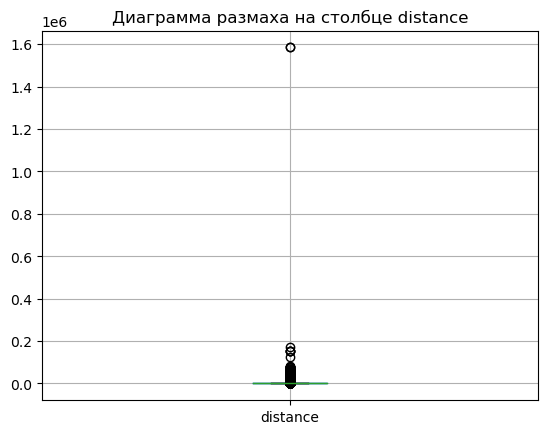

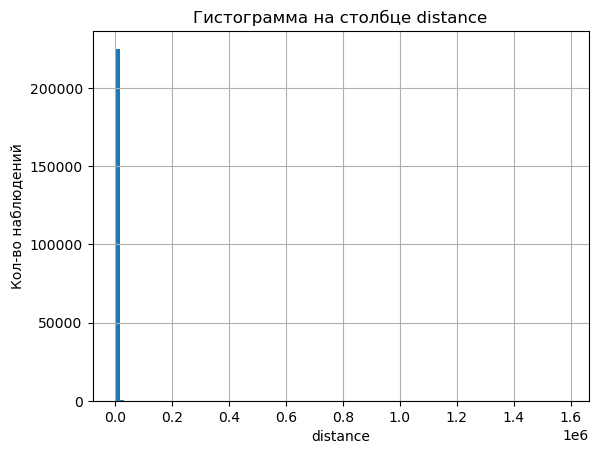

--------------------------------------------


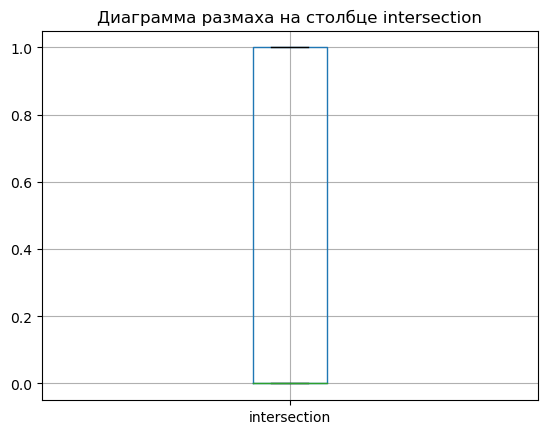

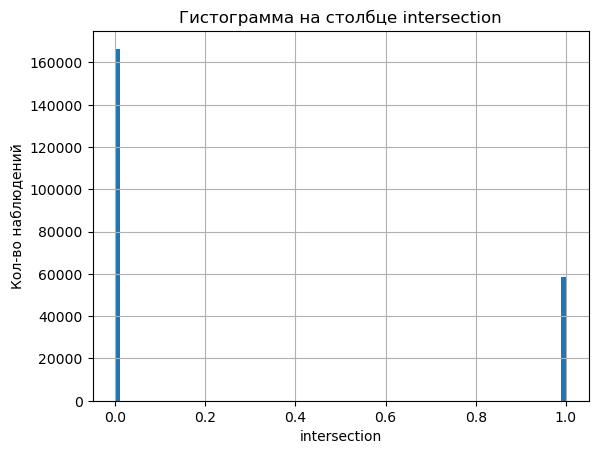

--------------------------------------------


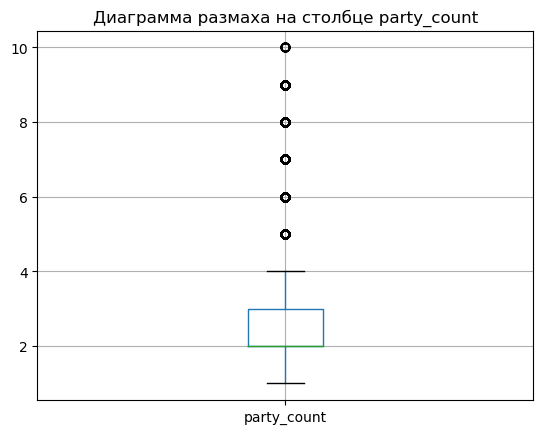

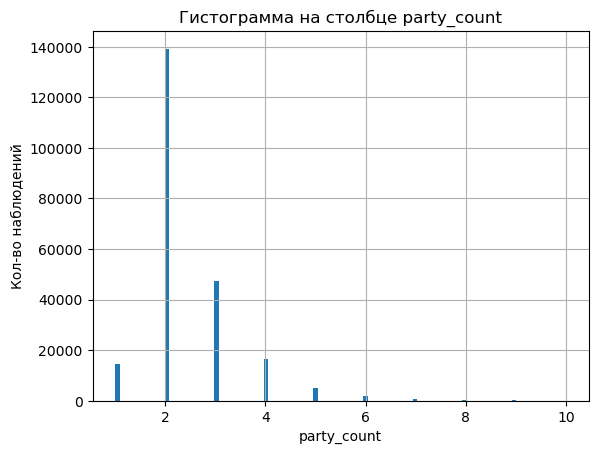

--------------------------------------------


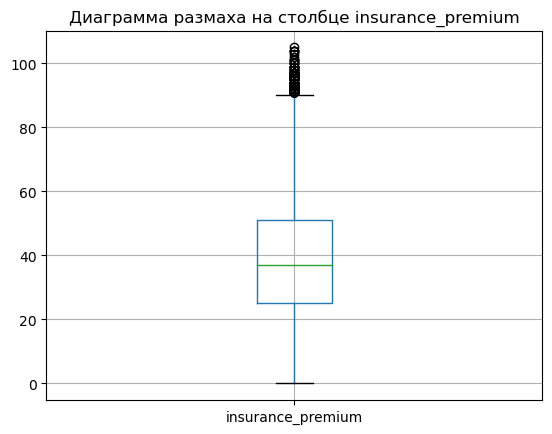

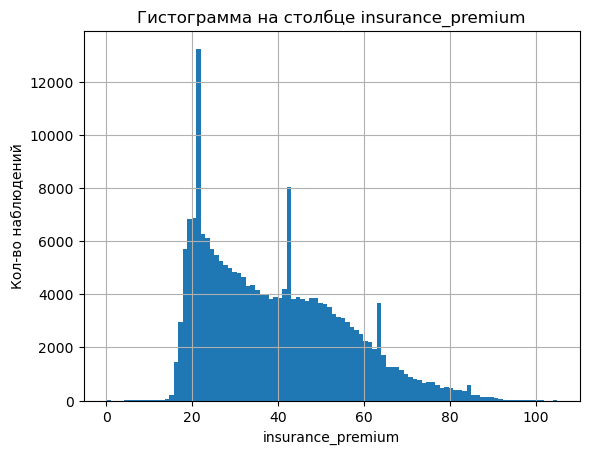

--------------------------------------------


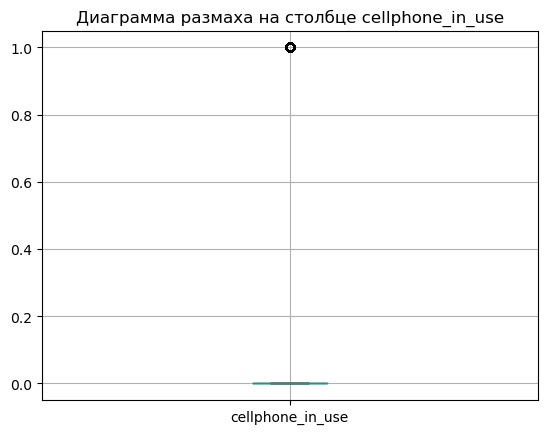

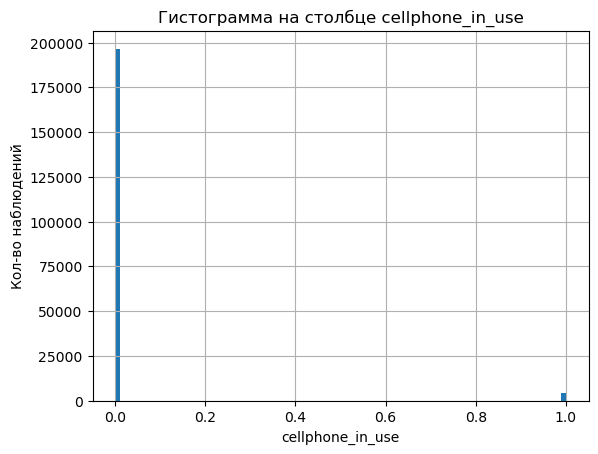

--------------------------------------------


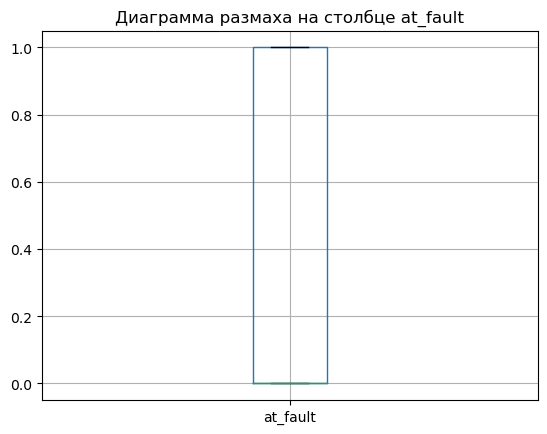

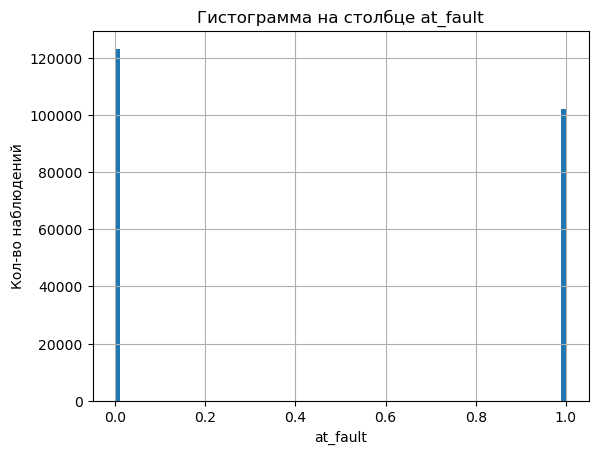

--------------------------------------------


In [47]:
data_spread(data, ['party_number', 'vehicle_age', 'distance', 'intersection', 'party_count', 'insurance_premium', 'cellphone_in_use', 'at_fault'])

In [48]:
uniqueness(data, ['vehicle_type', 'vehicle_transmission', 'county_location', 
       'direction', 'weather_1', 'location_type',
       'collision_damage', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'at_fault'])

Количество уникальных значений столбца vehicle_type: 5
['sedan' 'coupe' 'hatchback' 'minivan' 'other']
sedan        111672
coupe        104274
hatchback      5399
minivan        4296
other           137
Name: vehicle_type, dtype: int64
-----------------------------
Количество уникальных значений столбца vehicle_transmission: 2
['manual' 'auto' None]
auto      115163
manual    106197
Name: vehicle_transmission, dtype: int64
-----------------------------
Количество уникальных значений столбца county_location: 58
['san benito' 'el dorado' 'del norte' 'san bernardino' 'orange'
 'los angeles' 'riverside' 'san francisco' 'monterey' 'placer'
 'santa clara' 'santa barbara' 'alameda' 'sacramento' 'contra costa'
 'ventura' 'stanislaus' 'solano' 'san mateo' 'merced' 'fresno' 'marin'
 'san diego' 'santa cruz' 'yolo' 'tulare' 'imperial' 'humboldt' 'kern'
 'san luis obispo' 'calaveras' 'nevada' 'tuolumne' 'butte' 'mariposa'
 'shasta' 'sonoma' 'san joaquin' 'lake' 'amador' 'napa' 'kings'
 'mendocino'

Посмотрим сколько пропущенных значений содержит каждый столбец.

In [49]:
nan_values = []
nan_pres = []
data_nan_columns = []

for column in data:
    if  data[column].isna().sum() > 0:
        nan_values.append(data[column].isna().sum())
        nan_pres.append("{:.2%}".format(data[column].isna().sum()/len(data)))
        data_nan_columns.append(column)

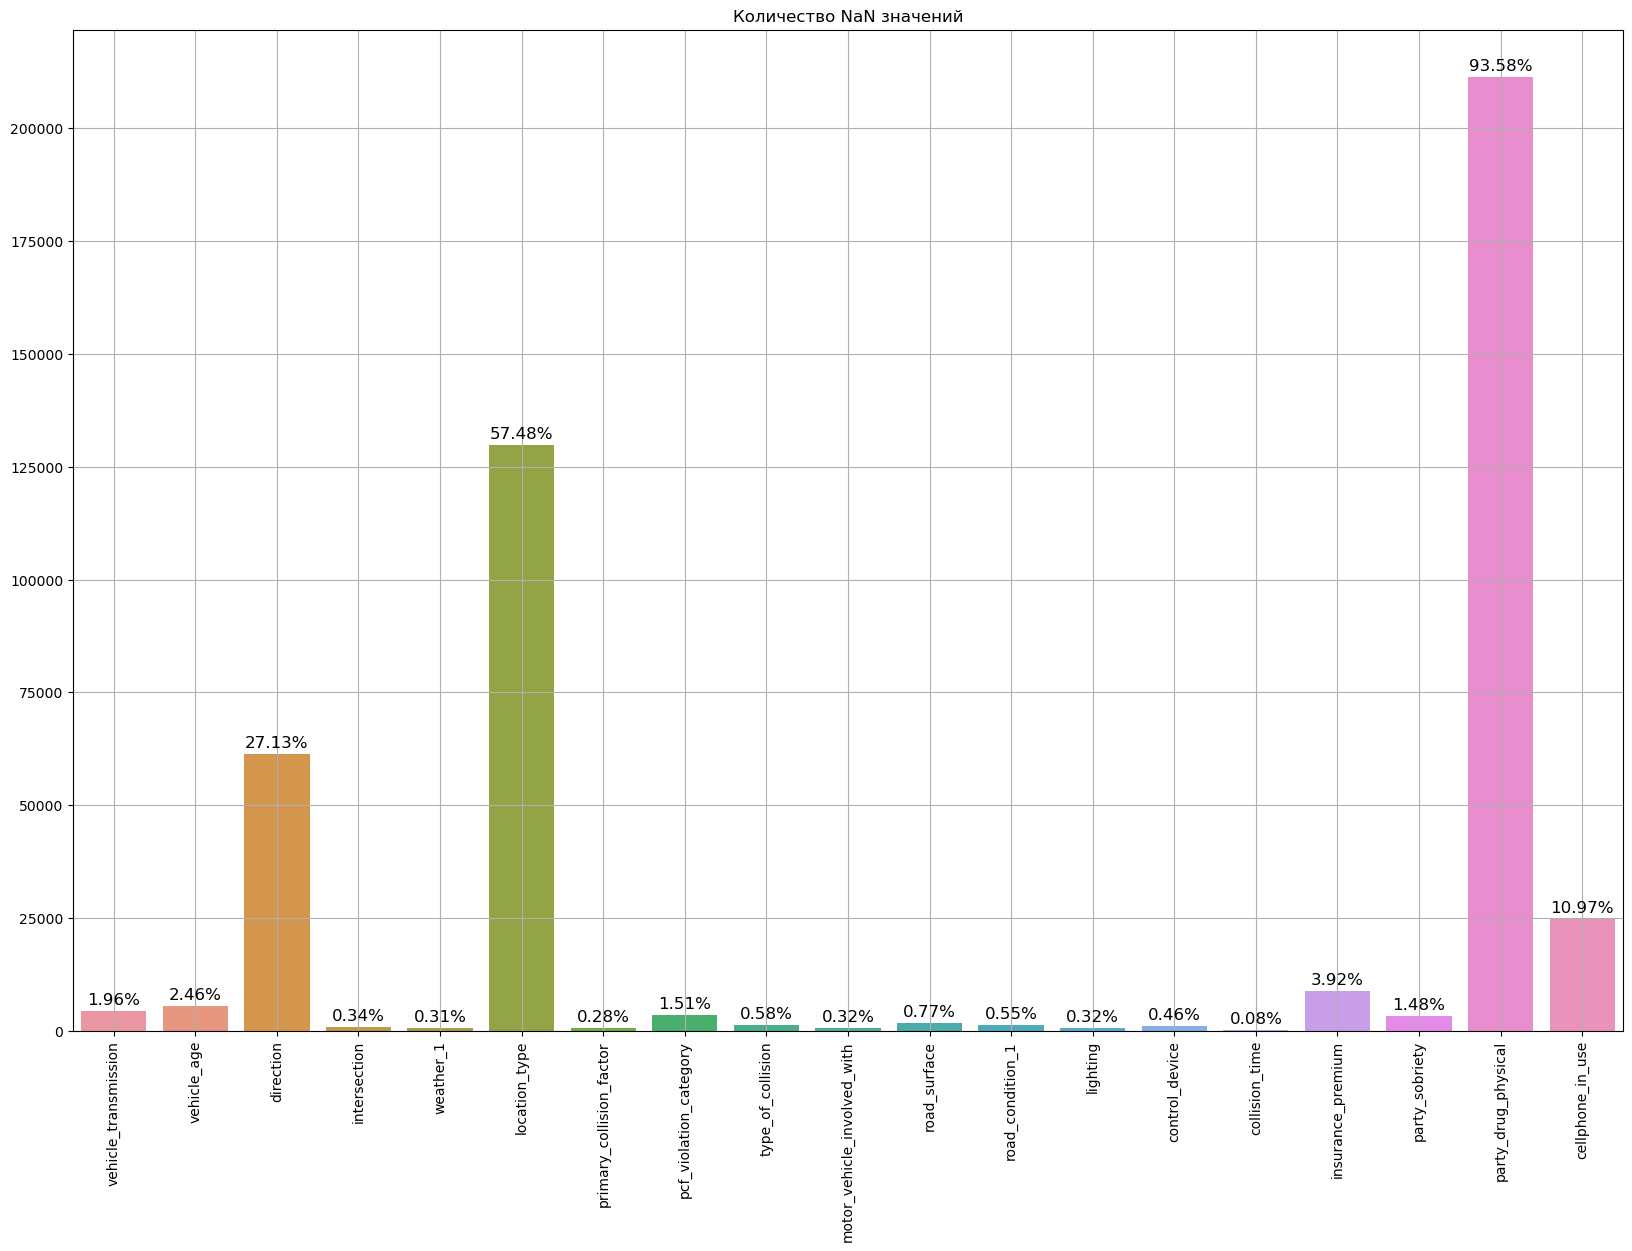

In [50]:
plt.figure(figsize=(20, 13))
plots = sns.barplot(x = data_nan_columns, y = nan_values)

for bar, pres in zip(plots.patches, nan_pres):
    plots.annotate(pres,
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
plt.title('Количество NaN значений')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Изучим дисбалланс классов.

In [51]:
display(data['at_fault'].value_counts(normalize=True))

0   0.55
1   0.45
Name: at_fault, dtype: float64

Заполним модой пропущенные значения в столбцах, которые лучше заполнить этим способом.

In [52]:
for column in ['primary_collision_factor', 'weather_1', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device']:
    data[column] = data[column].fillna(st.mode(data[column]))

Заполним значением unknown пропуски в столбцах, где лучше подойдёт этот способ.

In [53]:
for column in ['vehicle_transmission', 'direction', 'location_type', 'pcf_violation_category', 'party_sobriety', 'party_drug_physical']:
    data[column] = data[column].fillna('unknown')

Столбец `cellphone_in_use`перведеём в категориальный тип и заполним значением unknown.

In [54]:
def num_to_cat(x):
    if x == 1:
        return 'Yes'
    elif math.isnan(x):
        return 'unknown'
    return 'No'
    
data['cellphone_in_use'] = data['cellphone_in_use'].apply(num_to_cat)

In [55]:
display(data['cellphone_in_use'].value_counts(normalize=True))

No        0.87
unknown   0.11
Yes       0.02
Name: cellphone_in_use, dtype: float64

Найдём медиану для столбца `insurance_premium` и заполним случайными околомедианными значениями.

In [56]:
display(data['insurance_premium'].median())

37.0

In [57]:
def premium_std(x):
    if not math.isnan(x):
        return x
    if math.isnan(x):
        return random.randint(34, 40)
    
data['insurance_premium'] = data['insurance_premium'].apply(premium_std)

В столбце `vehicle_age` заменим значение 161, которое видимо было внесено ошибочно, значением 16. Пропуски в этом столбце заполним медианой.

In [58]:
data.loc[data['vehicle_age'] > 100, 'vehicle_age'] = 16

In [59]:
display(data['vehicle_age'].median())

5.0

In [60]:
for column in ['vehicle_age']:
    data[column] = data[column].fillna(np.median(data[column]))

Удалим строки с остальными пропусками.

In [61]:
data.dropna(inplace=True)

Приведем нужные столбцы к целочисленному типу.

In [62]:
for column in ['vehicle_age', 'distance', 'intersection', 'insurance_premium']:
    data[column] = data[column].astype('int')

Столбцы, содержащие дату и время, приведем к типу daytime.

In [63]:
for column in ['collision_date', 'collision_time']:
    data[column] = pd.to_datetime(data[column].astype(str))

Так как одно значение в столбце "дистанция до главной дороги" содержит нереальное значение, то мы удалим эту строку.

In [64]:
data = data.loc[data['distance'] != 1584000]

Создадим дополнительный столбец - месяц, это понадобится нам для дальнейшей работы.

In [65]:
month_list = {1 : 'January',
              2 : 'February',
              3 : 'March',
              4 : 'April',
              5 : 'May',
              6 : 'June',
              7 : 'July',
              8 : 'August',
              9 : 'September',
              10 : 'October',
              11 : 'November',
              12 : 'December'}

data['month'] = data['collision_date'].dt.month
del data['collision_date']

data['month'] = data['month'].replace(month_list)

Создадим дополнительные признаки - 4 столбца по времени суток - утро, день, вечер, ночь.

In [66]:
data['hour'] = data.collision_time.dt.hour

def time(x):
    if x < 6:
        return 'night'
    elif x < 12:
        return 'morning'
    elif x < 18:
        return 'daytime'
    return 'evening'

data['hour'] = data['hour'].apply(time)
del data['collision_time']

Посмотрим количество неявных дубликатов и удалим их.

In [67]:
print('Количество неявных дубликатов =', data.duplicated().sum())
data.drop_duplicates(inplace = True)
print('Количество неявных дубликатов после удаления =', data.duplicated().sum())

Количество неявных дубликатов = 3002
Количество неявных дубликатов после удаления = 0


Посмотрим на датафрейм.

In [68]:
df_info(data, 'data')

Информация о data (кол-во столбцов 28, кол-во строк 216321)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216321 entries, 0 to 225777
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   party_number                 216321 non-null  int64 
 1   vehicle_type                 216321 non-null  object
 2   vehicle_transmission         216321 non-null  object
 3   vehicle_age                  216321 non-null  int32 
 4   county_city_location         216321 non-null  object
 5   county_location              216321 non-null  object
 6   distance                     216321 non-null  int32 
 7   direction                    216321 non-null  object
 8   intersection                 216321 non-null  int32 
 9   weather_1                    216321 non-null  object
 10  location_type                216321 non-null  object
 11  collision_damage             216321 non-null  object
 12  party_count

,party_number,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,at_fault,month,hour
0,1,sedan,manual,3,3500,san benito,0,unknown,1,clear,unknown,fatal,1,vehicle code violation,dui,hit object,fixed object,dry,loose material,dark with street lights,functioning,19,"had been drinking, under influence",under drug influence,No,1,January,night
1,1,sedan,manual,4,0900,el dorado,200,north,0,clear,unknown,small damage,2,unknown,unknown,sideswipe,other motor vehicle,dry,normal,daylight,functioning,25,had not been drinking,unknown,No,0,January,daytime
2,1,coupe,manual,2,0800,del norte,0,unknown,1,clear,ramp,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,56,had not been drinking,unknown,No,0,January,morning
3,1,coupe,manual,9,0800,del norte,0,unknown,1,clear,ramp,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,56,had not been drinking,unknown,No,0,January,morning
4,2,sedan,auto,2,3612,san bernardino,300,south,0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,motor vehicle on other roadway,dry,normal,daylight,none,48,had not been drinking,unknown,No,0,January,morning
5,1,coupe,manual,7,3001,orange,1000,east,0,clear,highway,middle damage,4,vehicle code violation,dui,sideswipe,other motor vehicle,dry,construction,dark with street lights,none,44,"had been drinking, under influence",unknown,No,1,January,evening
6,1,coupe,auto,7,3001,orange,1000,east,0,clear,highway,middle damage,4,vehicle code violation,dui,sideswipe,other motor vehicle,dry,construction,dark with street lights,none,44,"had been drinking, under influence",unknown,No,1,January,evening
8,1,sedan,auto,6,1952,los angeles,200,north,0,clear,highway,small damage,3,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,57,had not been drinking,unknown,No,1,January,daytime
9,2,sedan,auto,8,3311,riverside,0,unknown,1,clear,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,44,had not been drinking,unknown,No,0,January,daytime
10,2,coupe,manual,7,3311,riverside,0,unknown,1,clear,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,44,had not been drinking,unknown,No,0,January,daytime


None

,party_number,vehicle_age,distance,intersection,party_count,insurance_premium,at_fault
count,216321.00,216321.00,216321.00,216321.00,216321.00,216321.00,216321.00
mean,1.68,5.27,590.23,0.26,2.41,39.21,0.45
std,0.82,3.07,2087.87,0.44,0.94,15.98,0.50
min,1.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,1.00,3.00,0.00,0.00,2.00,26.00,0.00
50%,2.00,5.00,100.00,0.00,2.00,37.00,0.00
75%,2.00,7.00,500.00,1.00,3.00,50.00,1.00
max,10.00,19.00,171600.00,1.00,10.00,105.00,1.00


Датафрейм содержит корректные значения, пропусков нет.

**Вывод**

После проведения предобработки получился датафрейм с 216325 наблюдением. Были удалены дубликаты, исправлены аномалии, пропуски были заполнены подходящим способом, данные прведены к подходящим типам.

**Выбор признаков для модели**

Для модели будем использовать следующий набор признаков:

- vehicle_type - тип кузова, Аварийности зависит от паттернов поведения водителя, люди предпочитающие скорость - выбирают купе, а семейные, предпочитающие вместительность, чаще выбирают minivan.
- hour - время проишествия. От вермени суток аварийность зависит.
- month - дата проишествия. Важная информация, но она у нас не по всему году. Оставим преобразовав ко дню недели.
- control_device - устройство управления. Не понятный мне столбец. Оставим на всякий случай. Если будут плохие метрики, можно попробовать удалить.
- lighting - освещенность, важный фактор, влияет на видимость на дороге.
- road_condition_1 - состояние улицы важнейший фактор влияющий на вероятность ДТП.
- road_surface - состояние покрытия - важнейший фактор.
- motor_vehicle_involved_with - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта с которым произошло столкновение может существовать. Например fixed object не может двигаться и не может быть виновником ДТП.
- type_of_collision - тип проишествия. Виновность в дтп может зависить от типа столкновения.
- pcf_violation_category - категория нарушения. Информативный столбец. Некоторые нарушения очевидным образом указывают на виновного.
- party_count - количество участников. Если участник один, то крайне вероятно, что он виновен
- location_type - тип дороги. Поведение водителей разнится в зависимости от нахождения на шоссе и в городе.
- weather_1 - погода. Погада важный фактор при вождении.
- intersection - перекресток является фактором повышающим вероятность аварии.
- direction - направление движения. Совместно со временем движения может свидетельствовать а том куда светит солнце.
- cellphone_in_use - Наличие телефона в машине, может стать причиной аварии.
- party_drug_physical - Состояние участника. Состояние водителя сильно влияет на его вождение.
- party_sobriety - трезвость участника. Так же сильно влияет на поведение и рекцию вадотеля.
- insurance_premium - страховая премия. Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот.
- vehicle_age - возраст машины нужно использовать по требованию заказчика

In [69]:
X = data[['at_fault', 'vehicle_type', 'hour', 'month', 'control_device', 'lighting', 'road_condition_1', 'road_surface', 
          'motor_vehicle_involved_with', 'type_of_collision', 'pcf_violation_category', 'party_count',
          'location_type', 'weather_1', 'intersection', 'direction', 'cellphone_in_use', 'party_drug_physical',
          'party_sobriety', 'insurance_premium', 'vehicle_age']]
X.head()

,at_fault,vehicle_type,hour,month,control_device,lighting,road_condition_1,road_surface,motor_vehicle_involved_with,type_of_collision,pcf_violation_category,party_count,location_type,weather_1,intersection,direction,cellphone_in_use,party_drug_physical,party_sobriety,insurance_premium,vehicle_age
0,1,sedan,night,January,functioning,dark with street lights,loose material,dry,fixed object,hit object,dui,1,unknown,clear,1,unknown,No,under drug influence,"had been drinking, under influence",19,3
1,0,sedan,daytime,January,functioning,daylight,normal,dry,other motor vehicle,sideswipe,unknown,2,unknown,clear,0,north,No,unknown,had not been drinking,25,4
2,0,coupe,morning,January,functioning,daylight,normal,dry,other motor vehicle,broadside,automobile right of way,2,ramp,clear,1,unknown,No,unknown,had not been drinking,56,2
3,0,coupe,morning,January,functioning,daylight,normal,dry,other motor vehicle,broadside,automobile right of way,2,ramp,clear,1,unknown,No,unknown,had not been drinking,56,9
4,0,sedan,morning,January,none,daylight,normal,dry,motor vehicle on other roadway,sideswipe,unsafe lane change,2,highway,clear,0,south,No,unknown,had not been drinking,48,2


**Посмотроим корреляцию с помощью библиотеки Phik**

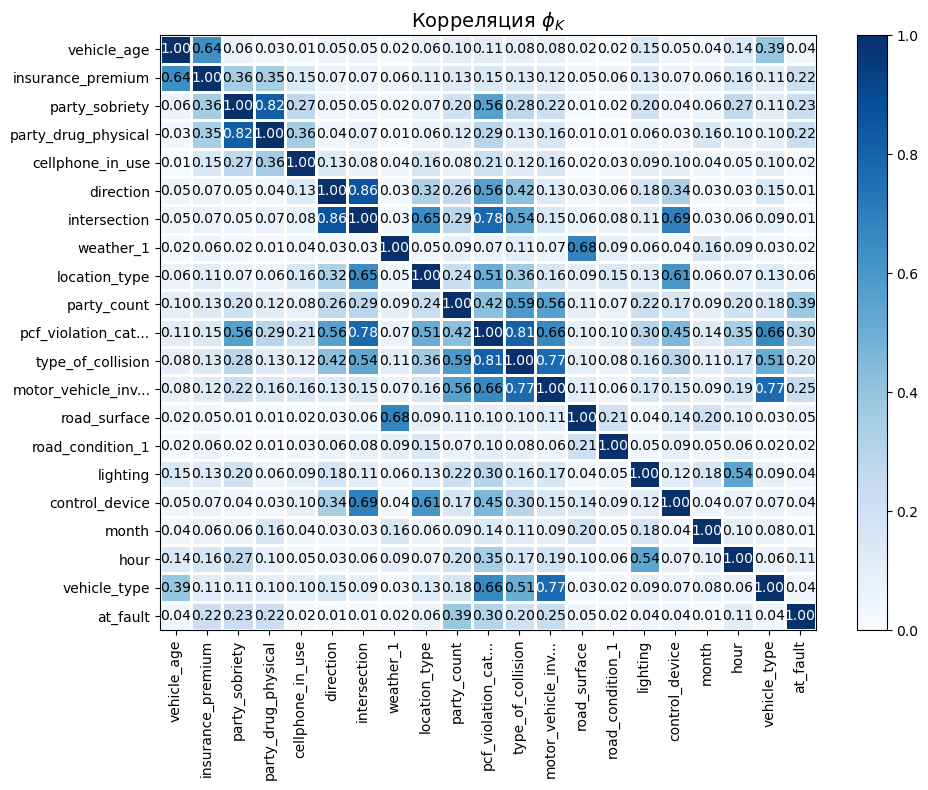

In [70]:
phik_overview = X.phik_matrix(interval_cols=['vehicle_age'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.0, 
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216321 entries, 0 to 225777
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   at_fault                     216321 non-null  int64 
 1   vehicle_type                 216321 non-null  object
 2   hour                         216321 non-null  object
 3   month                        216321 non-null  object
 4   control_device               216321 non-null  object
 5   lighting                     216321 non-null  object
 6   road_condition_1             216321 non-null  object
 7   road_surface                 216321 non-null  object
 8   motor_vehicle_involved_with  216321 non-null  object
 9   type_of_collision            216321 non-null  object
 10  pcf_violation_category       216321 non-null  object
 11  party_count                  216321 non-null  int64 
 12  location_type                216321 non-null  object
 13  weather_1     

Посмотрим корреляцию по нашему таргету `at_fault`

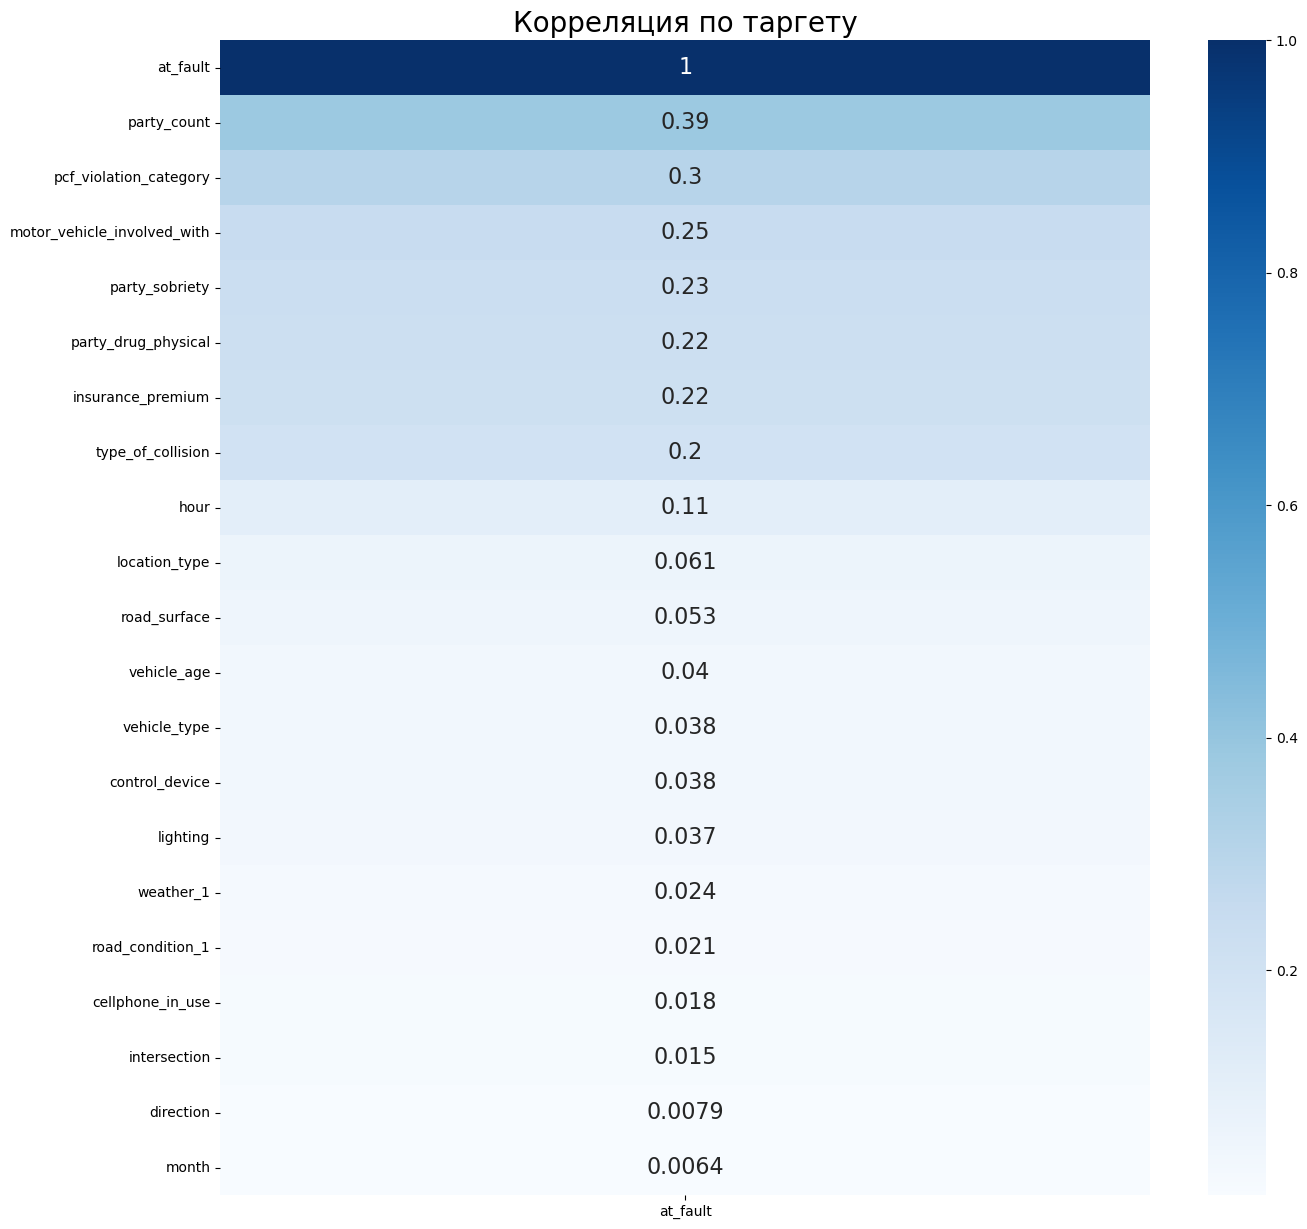

In [72]:
# Посмотрим корреляцию по нашему таргету
plt.figure(figsize=(15, 15))
sns.heatmap(phik_overview.sort_values(by = 'at_fault', ascending=False)[['at_fault']], cmap='Blues', annot=True, annot_kws={'size':16}, fmt='.2g')
plt.title('Корреляция по таргету', fontsize=20)
plt.show()

Разделим датасет на тренировочную, валидационную и тестовую выборки.

In [73]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X.drop('at_fault', axis=1),
                                                    X['at_fault'],
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=12345)

X_test, X_val, y_test, y_val = train_test_split(X_test_val,
                                                    y_test_val,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=12345)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(151424, 20) (151424,) (32449, 20) (32449,) (32448, 20) (32448,)


Разделим датасет на числовые и категориальные признаки.

In [74]:
numeric = ['insurance_premium', 'party_count', 'intersection', 'vehicle_age']
categories = ['vehicle_type', 'party_sobriety', 'party_drug_physical', 'hour', 'location_type', 
              'road_surface', 'road_condition_1', 'lighting', 'month', 'control_device',
              'motor_vehicle_involved_with', 'type_of_collision', 'pcf_violation_category', 'weather_1',
              'direction', 'cellphone_in_use']

'''col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False), categorical)],
                                remainder="passthrough"
                                  )

X_train_columns = X_train.columns
X_val_columns = X_val.columns
X_test_columns = X_test.columns


col_transformer.fit_transform(X_train)


X_test = col_transformer.transform(X_test)
X_val = col_transformer.transform(X_val)'''

'col_transformer = ColumnTransformer(\n                        transformers=[\n                            (\'scaler\', StandardScaler(), numerics),\n                            (\'ohe\', OneHotEncoder(sparse=False), categorical)],\n                                remainder="passthrough"\n                                  )\n\nX_train_columns = X_train.columns\nX_val_columns = X_val.columns\nX_test_columns = X_test.columns\n\n\ncol_transformer.fit_transform(X_train)\n\n\nX_test = col_transformer.transform(X_test)\nX_val = col_transformer.transform(X_val)'

**Закодируем категориальные признаки с помощью OneHotEncoder, а числовые признаки закодируем с помощью StandardScaler**

In [75]:
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown = 'error')

result_train = onehot_encoder.fit_transform(X_train[categories])
result_train = pd.DataFrame(result_train, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                    index=X_train.index)
X_train = result_train.join(X_train[numeric])
X_train.head()

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
108678,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,42,2,0,3
177929,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,

In [76]:
result_val = onehot_encoder.transform(X_val[categories])
result_val = pd.DataFrame(result_val, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                    index=X_val.index)
X_val = result_val.join(X_val[numeric])
X_val.head()

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
183993,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,53,2,0,9
28158,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0

In [77]:
result_test = onehot_encoder.transform(X_test[categories])
result_test = pd.DataFrame(result_test, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                    index=X_test.index)
X_test = result_test.join(X_test[numeric])
X_test.head()

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
194476,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,80,2,1,10
102330,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00

In [78]:
scaler = StandardScaler().fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])

pd.options.mode.chained_assignment = None

display(X_train.describe(), X_test.describe(), X_val.describe())

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
count,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.00,151424.

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
count,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,32448.00,3

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear end,type_of_collision_sideswipe,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
count,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,32449.00,3

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151424 entries, 108678 to 80545
Columns: 116 entries, vehicle_type_coupe to vehicle_age
dtypes: float64(116)
memory usage: 139.2 MB


In [80]:
X_train.head()

,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,party_sobriety_had_been_drinking_impairment_unknown,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not_applicable,party_sobriety_unknown,party_drug_physical_G,party_drug_physical_impairment_physical,party_drug_physical_not_applicable,party_drug_physical_sleepy_fatigued,party_drug_physical_under_drug_influence,party_drug_physical_unknown,hour_daytime,hour_evening,hour_morning,hour_night,location_type_highway,location_type_intersection,location_type_ramp,location_type_unknown,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_construction,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,lighting_dark_with_no_street_lights,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,control_device_functioning,control_device_none,control_device_not_functioning,control_device_obscured,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed_object,motor_vehicle_involved_with_motor_vehicle_on_other_roadway,motor_vehicle_involved_with_non_collision,motor_vehicle_involved_with_other_motor_vehicle,motor_vehicle_involved_with_other_object,motor_vehicle_involved_with_parked_motor_vehicle,motor_vehicle_involved_with_train,type_of_collision_broadside,type_of_collision_head_on,type_of_collision_hit_object,type_of_collision_other,type_of_collision_overturned,type_of_collision_rear_end,type_of_collision_sideswipe,pcf_violation_category_automobile_right_of_way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell_asleep,pcf_violation_category_following_too_closely,pcf_violation_category_hazardous_parking,pcf_violation_category_impeding_traffic,pcf_violation_category_improper_passing,pcf_violation_category_improper_turning,pcf_violation_category_lights,pcf_violation_category_other_equipment,pcf_violation_category_other_hazardous_violation,pcf_violation_category_other_improper_driving,pcf_violation_category_other_than_driver_or_pedestrian_,pcf_violation_category_pedestrian_right_of_way,pcf_violation_category_pedestrian_violation,pcf_violation_category_speeding,pcf_violation_category_traffic_signals_and_signs,pcf_violation_category_unknown,pcf_violation_category_unsafe_lane_change,pcf_violation_category_unsafe_starting_or_backing,pcf_violation_category_wrong_side_of_road,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,direction_east,direction_north,direction_south,direction_unknown,direction_west,cellphone_in_use_No,cellphone_in_use_Yes,cellphone_in_use_unknown,insurance_premium,party_count,intersection,vehicle_age
108678,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.17,-0.44,-0.59,-0.74
177929,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0

**Для оценки модели используем метрику Recall, так как для нашей задачи важно определить наиболее опасный маршрут, чтобы по возможности исключить его из предполагаемых маршрутов движения**

Создадим таблицу с временем обучения и предсказания и значением метрики Recall

In [81]:
analytics = pd.DataFrame(columns=['Recall', 'LearningTime', 'PredictTime'])

**Обучим разные модели и выберем лучшую модель**

**Модель Дерево решений**

In [82]:
grid = {'max_depth' : np.arange(6, 18),
    'criterion' : ['gini', 'entropy']
}

dt = GridSearchCV(DecisionTreeClassifier(random_state=12345),
                     grid, cv = 5, scoring = 'recall', n_jobs=-1)
dt.fit(X_train, y_train)
dt.best_params_

{'criterion': 'entropy', 'max_depth': 16}

In [83]:
# Дерево решений
import time # Не знаю почему, постоянно просит библиотеку именно на этом этапе, такое ощущение, что код забывает импорт в самом начале, поэтому вывел её сюда. Знаю, что не эстетично

model_dtr, learning_time_dtr = learning_time(DecisionTreeClassifier(criterion = 'entropy', max_depth=16, random_state=12345),
                                             X_train, y_train)
predicts_dtr, predict_time_dtr = predict_time(model_dtr, X_val)
recall_dtr = "{:.2%}".format(recall_score(y_val, predicts_dtr))
alter_table(analytics, 'DecisionTreeClassifier', recall_dtr, learning_time_dtr, predict_time_dtr)

,Recall,LearningTime,PredictTime
DecisionTreeClassifier,50.19%,2.04,0.02


**Модель Случайный лес**

In [84]:
grid = { 
    'n_estimators': [40, 50, 60],
    'max_depth' : np.arange(45, 55),
    'criterion' : ['gini']
}

rf = GridSearchCV(RandomForestClassifier(random_state=12345),
                     grid, cv = 5, scoring = 'recall', n_jobs=-1)
rf.fit(X_train, y_train)
rf.best_params_

{'criterion': 'gini', 'max_depth': 54, 'n_estimators': 60}

In [85]:
# Случайный лес

model_rfr, learning_time_rfr = learning_time(RandomForestClassifier(criterion = 'gini', 
                                                                    max_depth = 54, 
                                                                    n_estimators = 60, 
                                                                    random_state=12345),
                                             X_train, y_train)
predicts_rfr, predict_time_rfr = predict_time(model_rfr, X_val)
recall_rfr = "{:.2%}".format(recall_score(y_val, predicts_rfr))
alter_table(analytics, 'RandomForestClassifier', recall_rfr, learning_time_rfr, predict_time_rfr)

,Recall,LearningTime,PredictTime
DecisionTreeClassifier,50.19%,2.04,0.02
RandomForestClassifier,56.76%,34.44,0.93


**Модель градиентного бустинга LightGBM**

In [86]:
# LGBMClassifier

param_grid = {
    'num_leaves': [51, 61, 71, 81],
    'learning_rate': [0.1, 1.0, 1.5]
}

lgb_estimator = lgb.LGBMClassifier(task='train', boosting_type='gbdt', objective='regression', verbose=-1)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, 
                       scoring = 'recall', cv=5, n_jobs=-1, error_score='raise')
lgb_model = gsearch.fit(X_train, y_train)
lgb_model.best_params_

{'learning_rate': 1.5, 'num_leaves': 81}

In [87]:
# LGBMClassifier

lgb_model, learning_time_lgb = learning_time(lgb.LGBMClassifier(learning_rate = 1.5, num_leaves = 81, boosting_type='gbdt', random_state=12345),
                                             X_train, y_train)
predicts_lgb, predict_time_lgb = predict_time(lgb_model, X_val)
recall_lgb = "{:.2%}".format(recall_score(y_val, predicts_lgb))
alter_table(analytics, 'LGBMClassifier', recall_lgb, learning_time_lgb, predict_time_lgb)

,Recall,LearningTime,PredictTime
DecisionTreeClassifier,50.19%,2.04,0.02
RandomForestClassifier,56.76%,34.44,0.93
LGBMClassifier,52.33%,1.21,0.10


**Модель градиентного бустинга CatBoost**

In [88]:
#Catboost

model_cbr = CatBoostClassifier(loss_function='Logloss', silent=True, learning_rate=0.1, n_estimators=100, random_state=12345)
parameters_cbr = {'max_depth':np.arange(8, 15)}
catboost_grid = model_cbr.grid_search(parameters_cbr,
            X_train, y_train,
            cv=3,
            plot=False)


bestTest = 0.5364244789
bestIteration = 99

0:	loss: 0.5364245	best: 0.5364245 (0)	total: 2.75s	remaining: 16.5s

bestTest = 0.5356921505
bestIteration = 99

1:	loss: 0.5356922	best: 0.5356922 (1)	total: 5.42s	remaining: 13.6s

bestTest = 0.5344483028
bestIteration = 98

2:	loss: 0.5344483	best: 0.5344483 (2)	total: 9.73s	remaining: 13s

bestTest = 0.534658568
bestIteration = 99

3:	loss: 0.5346586	best: 0.5344483 (2)	total: 15.3s	remaining: 11.5s

bestTest = 0.5350456267
bestIteration = 95

4:	loss: 0.5350456	best: 0.5344483 (2)	total: 26.3s	remaining: 10.5s

bestTest = 0.5365688508
bestIteration = 98

5:	loss: 0.5365689	best: 0.5344483 (2)	total: 44.9s	remaining: 7.49s

bestTest = 0.5383400995
bestIteration = 85

6:	loss: 0.5383401	best: 0.5344483 (2)	total: 1m 27s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.5325919721
bestIteration = 99

Training on fold [1/3]

bestTest = 0.5318893604
bestIteration = 99

Training on fold [2/3]

bestTest = 0.53447

In [89]:
#CatBoost

model_cbr, learning_time_cbr = learning_time(CatBoostClassifier(loss_function='Logloss', 
                                                                n_estimators=100, 
                                                                silent=True, 
                                                                depth = 12),
                                             X_train, y_train)
predicts_cbr, predict_time_cbr = predict_time(model_cbr, X_val)
recall_cbr = "{:.2%}".format(recall_score(y_val, predicts_cbr))
alter_table(analytics, 'CatBoostClassifier', recall_cbr, learning_time_cbr, predict_time_cbr)

,Recall,LearningTime,PredictTime
DecisionTreeClassifier,50.19%,2.04,0.02
RandomForestClassifier,56.76%,34.44,0.93
LGBMClassifier,52.33%,1.21,0.10
CatBoostClassifier,57.27%,10.87,0.05


Лучшие показатели метрики Recall показала модель CatBoost. Поэтому выберем её для получения предсказаний на тестовой выборке. Посмотрим кроме мертрики Recall еще метрики Precision и F1

In [90]:
best_model = CatBoostClassifier(loss_function='Logloss', n_estimators=100, silent=True, depth = 12).fit(X_train, y_train)
predicts = best_model.predict(X_test)
print(f'Метрика Recall на тестовых данных = {"{:.2%}".format(recall_score(y_test, predicts))}')
print(f'Метрика Precision на тестовых данных = {"{:.2%}".format(precision_score(y_test, predicts))}')
print(f'Метрика F1 на тестовых данных = {"{:.2%}".format(f1_score(y_test, predicts))}')

Метрика Recall на тестовых данных = 57.03%
Метрика Precision на тестовых данных = 69.70%
Метрика F1 на тестовых данных = 62.73%


Построим ROC_AUC кривую, рассмотрим матрицу ошибок, полноту и точность.

0.7658928205395261
Threshold value is: 0.5100055829540127


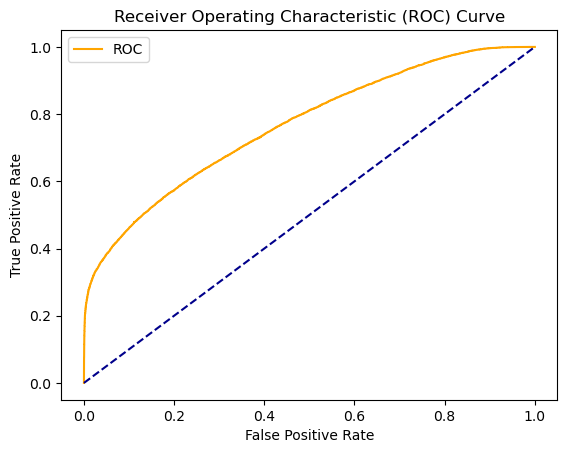

In [91]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fpr, tpr, thresholds = roc_curve(y_val, best_model.predict_proba(X_val)[:, 1])
print(roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

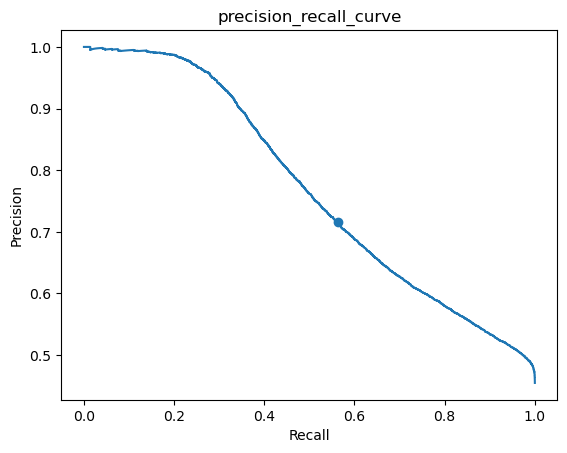

In [92]:
precision, recall, _ = precision_recall_curve(y_val, best_model.predict_proba(X_val)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(y_val, best_model.predict_proba(X_val)[:, 1]>=optimal_threshold), 
            precision_score(y_val, best_model.predict_proba(X_val)[:, 1]>=optimal_threshold))
plt.title("precision_recall_curve")
plt.show()

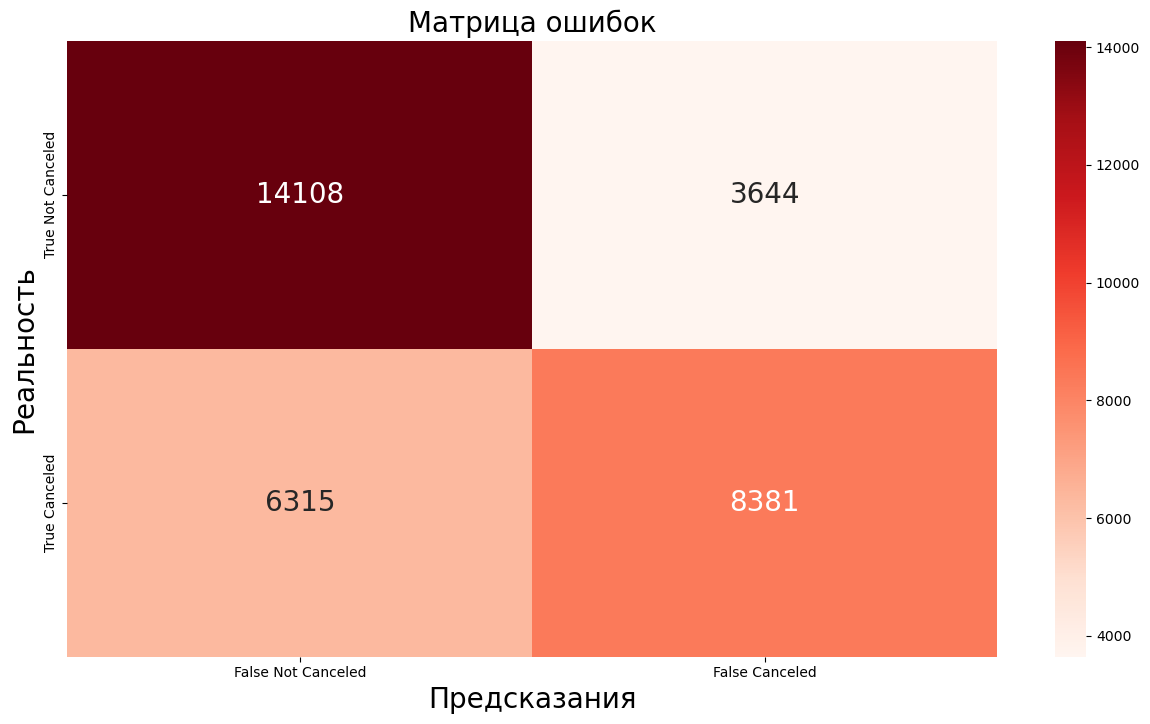

In [93]:
# Создадим матрицу ошибок CatBoost

cm_cb = confusion_matrix(y_test, predicts)
cm_cb_data = pd.DataFrame(cm_cb,
                           index=['True Not Canceled', 'True Canceled'],
                           columns=['False Not Canceled', 'False Canceled'])

plt.figure(figsize=(15,8))
sns.heatmap(cm_cb, xticklabels=cm_cb_data.columns, yticklabels=cm_cb_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Предсказания', size=20)
plt.ylabel('Реальность', size=20);

Модель достаточно хорошо предсказывает Positive так и Negative. Ошибки есть, они смещены в сторону излишненго прогноза Positive.

## Проведите анализ важности факторов ДТП

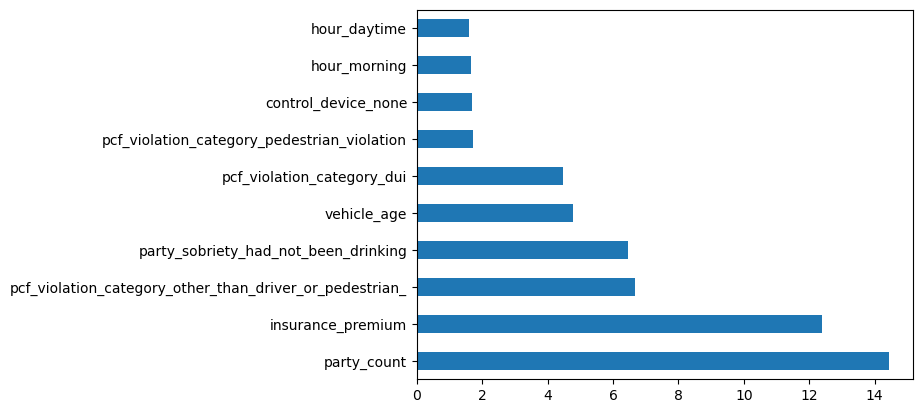

In [94]:
importances_cb = pd.Series((best_model.get_feature_importance()), index=X_train.columns)
importances_cb.nlargest(10).plot(kind='barh')
plt.show()

Самыми важными произнаками, влияющими на возможность ДТП являются количество участников, страховая премия. категория нарушения, трезвость участника и возраст автомобиля.

## Выводы

Нам удалось обучить модель на тестовых данных и получить метрику Recall равную 57%, precision - 69.7%, а f1 - 62.7%. Это недостаточно хороший показатель, однако на предсказаниях мы имеем:

неправильно угадываем порядка 24% данных, которые относятся к первому классу
чаще всего мы будем угадывать класс 1 - в районе 29% данных. Это не может не радовать.
класс 0 мы будем угадывать в 24% от случая.
а наименьший процент из всех представленных - неудачные предсказания класса 0 (19%)
Если отвечать на первоначальный вопрос: "Возможно ли прогнозировать?", я бы сказал нет, точнее, не на этих данных. Будем честны, большинство факторов из выборки будут известны уже после проишествия. Нам же нужны совсем иные данные, которые мы будем знать только, когда человек сел в машину и выбрал маршрут. К примеру, я бы добавил в таблицу характеристик клиента следующие факторы:

возраст водителя, который будет прямо влиять на время реакции,
стаж, от этого будет зависить как он поведёт себя в той или иной ситуации
среднюю сокорость вождения
количество нарушений за всё время за рулём
возможно, можно провести исследования и добавить сюда место работы, ведь те же таксисты и водители дального следования, скорее всего, будут реже попадать в подобные ситуации, чем пилоты самолёта.
Вообщем характеристики самой "личности" человека, чтобы было понятно кто именно сел за руль. Тогда, возможно, у нас будет вероятность обучить модель выше 70% по метрике recall.